# Prêt à dépenser : Construire un modèle de scoring


## Contexte

"Prêt à dépenser" (Home Credit) est une société financière qui propose des crédits à la consommation pour des personnes ayant peu ou pas d'historique de prêt.
Pour accorder un crédit à la consommation, l'entreprise calcule la probabilité qu'un client le rembourse, ou non. Elle souhaite donc développer un algorithme de scoring pour aider à décider si un prêt peut être accordé à un client.

Les chargés de relation client seront les utilisateurs du modèle de scoring. Puisqu'ils s'adressent aux clients, ils ont besoin que votre modèle soit facilement interprétable. Les chargés de relation souhaitent, en plus, disposer d'une mesure de l'importance des variables qui ont poussé le modèle à donner cette probabilité à un client.


## Chargement des modules du projet

Afin de simplifier le Notebook, le code métier du projet est placé dans le répertoire [src/](../src/).


In [1]:
# Import project modules from source directory

# Hide warnings
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)

# System modules
import os
import sys

# Append source directory to system path
src_path = os.path.abspath(os.path.join("../src"))
if src_path not in sys.path:
    sys.path.append(src_path)

# Helper functions
import data.helpers as data_helpers
import features.helpers as feat_helpers
import visualization.helpers as vis_helpers
import models.helpers as models_helpers



Nous allons utiliser le langage [Python](https://www.python.org/about/gettingstarted/), et présenter ici le code, les résultats et l'analyse sous forme de [Notebook JupyterLab](https://jupyterlab.readthedocs.io/en/stable/getting_started/overview.html).

Nous allons aussi utiliser les bibliothèques usuelles d'exploration et analyse de données, afin d'améliorer la simplicité et la performance de notre code :
  * [NumPy](https://numpy.org/doc/stable/user/quickstart.html) et [Pandas](https://pandas.pydata.org/docs/user_guide/index.html) : effectuer des calculs scientifiques (statistiques, algèbre, ...) et manipuler des séries et tableaux de données volumineuses et complexes
  * [scikit-learn](https://scikit-learn.org/stable/getting_started.html) et [XGBoost](https://xgboost.readthedocs.io/en/latest/get_started.html) : pour effectuer des analyses prédictives 
  * [Matplotlib](https://matplotlib.org/stable/tutorials/introductory/usage.html), [Pyplot](https://matplotlib.org/stable/tutorials/introductory/pyplot.html), [Seaborn](https://seaborn.pydata.org/tutorial/function_overview.html) et [Plotly](https://plotly.com/python/getting-started/) : générer des graphiques lisibles, intéractifs et pertinents


In [2]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd


# sklearn tools for model evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.inspection import plot_partial_dependence


# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from lime.lime_tabular import LimeTabularExplainer
import shap


# print the JS visualization code to the notebook
shap.initjs()

# Accelerate the development cycle
SAMPLE_FRAC: float = 1

# Prevent excessive memory usage used by plotly
DRAW_PLOTS: bool = True


## Chargement des données

Les données mises à disposition sont issues de [Home Credit](https://www.homecredit.net/) et plus précisément de la compétition hébergée sur Kaggle [Home Credit Default Risk - Can you predict how capable each applicant is of repaying a loan?](https://www.kaggle.com/c/home-credit-default-risk)

Les données sont fournies sous la forme de plusieurs fichiers CSV pouvant être liés entre eux de la manière suivante :

![Home Credit data relations](https://storage.googleapis.com/kaggle-media/competitions/home-credit/home_credit.png)

_source : [Introduction: Home Credit Default Risk Competition](https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction) by [Will Koehrsen](https://www.kaggle.com/willkoehrsen)_


In [3]:
# Download and extract the raw data
data_helpers.download_extract_zip(
    zip_file_url="https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/Parcours_data_scientist/Projet+-+Impl%C3%A9menter+un+mod%C3%A8le+de+scoring/Projet+Mise+en+prod+-+home-credit-default-risk.zip",
    files_names=(
        "application_test.csv",
        "application_train.csv",
        "bureau_balance.csv",
        "bureau.csv",
        "credit_card_balance.csv",
        "installments_payments.csv",
        "POS_CASH_balance.csv",
        "previous_application.csv",
    ),
    target_path="../data/raw/",
)


Nous allons charger toutes les données du fichier `application_train.csv` afin de travailler préparer les données du jeu d'entraînement et de test (variable `TARGET` vaut `O` : le client n'a pas fait défaut ou `1` : le client a fait défaut). Nous les séparerons les jeux de données au moment de l'entraînement et évaluation de nos modèles.

Les fichiers contiennent un grand nombre de variables booléennes et catégorielles que nous pouvons déjà typer comme telles.


In [4]:
# Read column names
application_train_column_names = pd.read_csv(
    "../data/raw/application_train.csv", nrows=0
).columns.values

# TARGET variable must be present in the Train datase
if "TARGET" not in application_train_column_names:
    raise ValueError(
        "TARGET column not found in application_train.csv. Please check that the file is not corrupted."
    )

# SK_ID_CURR variable must be present in the Train datase
if "SK_ID_CURR" not in application_train_column_names:
    raise ValueError(
        "SK_ID_CURR column not found in application_train_column_names.csv. Please check that the file is not corrupted."
    )

# Set column types according to fields description (../data/raw/HomeCredit_columns_description.csv)
# Categorical variables
column_types = {
    col: "category"
    for col in application_train_column_names
    if col.startswith(("NAME_",))
    or col.endswith(("_TYPE"))
    or col
    in [
        "CODE_GENDER",
        "WEEKDAY_APPR_PROCESS_START",
        "FONDKAPREMONT_MODE",
        "HOUSETYPE_MODE",
        "WALLSMATERIAL_MODE",
        "EMERGENCYSTATE_MODE",
    ]
}
# Boolean variables
column_types |= {
    col: bool
    for col in application_train_column_names
    if col.startswith(("FLAG_", "REG_", "LIVE_"))
}

# Load application data
app_df = pd.read_csv(
    "../data/raw/application_train.csv",
    dtype=column_types,
    true_values=["Y", "Yes", "1"],
    false_values=["N", "No", "0"],
    na_values=["XNA"], # bad values
)

# Sample to speed up development
if  float == type(SAMPLE_FRAC) and 0 < SAMPLE_FRAC < 1:
    app_df = app_df.sample(frac=SAMPLE_FRAC)

# Let's display basic statistical info about the data
app_df.describe(include="all")


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511,307507,307511,307511,307511.000000,3.075110e+05,3.075110e+05,307499.000000,...,307511,307511,307511,307511,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
unique,NaN,NaN,2,2,2,2,NaN,NaN,NaN,NaN,...,2,2,2,2,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,Cash loans,F,False,True,NaN,NaN,NaN,NaN,...,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,278232,202448,202924,213312,NaN,NaN,NaN,NaN,...,305011,307328,307355,307408,NaN,NaN,NaN,NaN,NaN,NaN
mean,278180.518577,0.080729,NaN,NaN,NaN,NaN,0.417052,1.687979e+05,5.990260e+05,27108.573909,...,NaN,NaN,NaN,NaN,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,102790.175348,0.272419,NaN,NaN,NaN,NaN,0.722121,2.371231e+05,4.024908e+05,14493.737315,...,NaN,NaN,NaN,NaN,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,100002.000000,0.000000,NaN,NaN,NaN,NaN,0.000000,2.565000e+04,4.500000e+04,1615.500000,...,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,NaN,NaN,NaN,NaN,0.000000,1.125000e+05,2.700000e+05,16524.000000,...,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,NaN,NaN,NaN,NaN,0.000000,1.471500e+05,5.135310e+05,24903.000000,...,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,367142.500000,0.000000,NaN,NaN,NaN,NaN,1.000000,2.025000e+05,8.086500e+05,34596.000000,...,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000


In [5]:
app_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: bool(34), category(14), float64(65), int64(9)
memory usage: 187.7 MB


Le jeu de données contient 122 variables, dont la variable cible que nous devons estimer : `TARGET`. Parmis ces variables, nous avons :
- 34 variables booléennes
- 14 variables catégorielles
- 74 variables numériques

## Analyse exploratoire

Nous allons analyser la distribution de quelques variables.

### Variable cible

Voyons spécifiquement la distribution de la variable `TARGET` qui est celle que nous devrons estimer par la suite.
Les valeurs nulles représentent notre jeu d'entrainement.
Nous pouvons oberver que nous avons à faire à un problème de __classification binaire déséquilibré__ (il y a deux valeurs possibles, mais les deux valeurs ne sont pas également représentées).
Ceci va influencer la manière dont nous allons construire et entraîner notre modèle.


In [6]:
# Let's plot the distribution of the TARGET variable
if DRAW_PLOTS:
    fig = px.bar(
        app_df["TARGET"].replace({
            "0": "TARGET=0 : payments OK", 
            "1": "TARGET=1 : payment difficulties", 
        }).value_counts(),
        title="Distribution of TARGET variable",
        width=800,
        height=400,
    ).update_xaxes(
        title="TARGET",
    ).update_yaxes(title="Count")
    fig.show()


### Valeurs vides

Nous voyons que toutes les variables ont moins de 30% de valeurs vides, et près de la moitié a moins de 1% de valeurs vides. Le jeu de données est donc relativement bien rempli, ce qui ne devrait pas poser de problème pour la suite.


In [7]:
# Let's display variables with missing values ratio
if DRAW_PLOTS:
    vis_helpers.plot_empty_values(app_df)


### Valeurs impossibles

Quelques valeurs présentes dans les données semblent impossibles. Nous allons supprimer ces "outliers".


In [8]:
# Define data constraints
data_constraints = {
    "DAYS_EMPLOYED": {"min": -35000, "max": 0,}, # max 100 years, only negative values
}

if DRAW_PLOTS:
    # Let's display box plots for variables with outliers
    vis_helpers.plot_boxes(app_df, plot_columns=data_constraints.keys(), categorical_column="TARGET")

# Remove values that are outside possible range
app_df = feat_helpers.drop_impossible_values(
    app_df, constraints=data_constraints,
)


### Variables quantitatives

Nous allons simplement afficher la distribution de quelques variables numériques. Nous voyons déjà que selon la valeur de TARGET, la distribution (moyenne) des variables peut être sensiblement différente.


In [9]:
# Draw the BoxPlots of some numeric columns, split per Target
if DRAW_PLOTS:
    vis_helpers.plot_boxes(app_df,
        plot_columns=[
            "AMT_INCOME_TOTAL",
            "AMT_CREDIT",
            "AMT_ANNUITY",
            "AMT_GOODS_PRICE",
            "DAYS_BIRTH",
            "DAYS_EMPLOYED",
            "OWN_CAR_AGE",
            "REGION_RATING_CLIENT",
            "REGION_RATING_CLIENT_W_CITY",
            "EXT_SOURCE_1",
            "EXT_SOURCE_2",
            "EXT_SOURCE_3",
            "DAYS_LAST_PHONE_CHANGE",
            "AMT_REQ_CREDIT_BUREAU_YEAR",
        ],
        categorical_column="TARGET",
    )


### Variables qualitatives

De la même manière, nous allons simplement afficher la distribution de quelques variables catégorielles. Nous voyons déjà que selon la valeur de TARGET, la distribution (répartition entre classes) des variables peut être sensiblement différente (`TARGET=0` pour 77,6% des `NAME_CONTRACT_TYPE="Cash loans"`, tandis que `TARGET=0` pour 93,1% des `NAME_CONTRACT_TYPE="Revolving loans"`).
Certaines variables ont une répartition très inégale entre classes (`FLAG_MOBIL` vaut systématiquement `True` et jamais `False`).


In [10]:
# Draw the Bar charts of some categorical columns, split per Target
if DRAW_PLOTS:
    vis_helpers.plot_categories_bars(app_df,
        plot_columns=[
            "NAME_CONTRACT_TYPE",
            "CODE_GENDER",
            "FLAG_OWN_CAR",
            "FLAG_OWN_REALTY",
            "NAME_INCOME_TYPE",
            "NAME_EDUCATION_TYPE",
            "NAME_FAMILY_STATUS",
            "NAME_HOUSING_TYPE",
            "OCCUPATION_TYPE",
            "FLAG_MOBIL",
        ],
        categorical_column="TARGET",
    )


### Encodage des catégories

Lorsque les données qualitatives ne sont pas ordinales (on ne peu pas les classer selon un certain ordre), l'encodage "One Hot Encoding" sera plus performant que le "Label Encoding".


In [11]:
## Pandas get_dummies() categorical data encoder
# https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html
# Convert categorical variable into dummy/indicator variables.
# a.k.a "One Hot Encoding"

app_df = pd.get_dummies(app_df, dtype=bool)

app_df.describe(include="bool")


,FLAG_OWN_CAR,FLAG_OWN_REALTY,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,...,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
count,252137,252137,252137,252137,252137,252137,252137,252137,252137,252137,...,252137,252137,252137,252137,252137,252137,252137,252137,252137,252137
unique,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
top,False,True,True,True,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
freq,157719,171082,252136,252125,190830,251601,182123,236126,247790,236525,...,251130,244626,250217,250616,250778,197798,198699,247695,131341,250191


Nous avons ici créé 134 nouvelles variables booléennes qui correspondent aux différentes classes de chacune des 14 anciennes variables catégorielles qui ont été encodées et supprimées.


## Feature Engineering

Nous allons tenter d'enrichir nos données en intégrant des variables qui sont des compositions non linéaires des variables existantes.


### Données métier

Afin d'apporter plus de sens aux données que nous allons fournir à nos modèles, nous pouvons faire appel aux experts métier qui peuvent nous indiquer des informations qui sont réputées importantes afin de prédire si un client risque d'avoir des problèmes de remboursement ou non.

Les informations métier pertinentes sont :
- Montant emprunté / Prix du bien acheté : `AMT_CREDIT / AMT_GOODS_PRICE`
- Montant des annuités / Montant emprunté : `AMT_ANNUITY / AMT_CREDIT`
- Montant des annuités / Revenu annuel : `AMT_ANNUITY / AMT_INCOME_TOTAL`
- Ancienneté au travail / Age : `DAYS_EMPLOYED / DAYS_BIRTH`


In [12]:
# Create the new features
app_df["CREDIT_PRICE_RATIO"] = app_df["AMT_CREDIT"] / app_df["AMT_GOODS_PRICE"]
app_df["ANNUITY_CREDIT_RATIO"] = app_df["AMT_ANNUITY"] / app_df["AMT_CREDIT"]
app_df["ANNUITY_INCOME_RATIO"] = app_df["AMT_ANNUITY"] / app_df["AMT_INCOME_TOTAL"]
app_df["EMPLOYED_BIRTH_RATIO"] = app_df["DAYS_EMPLOYED"] / app_df["DAYS_BIRTH"]

# Draw the BoxPlots for these features
if DRAW_PLOTS:
    vis_helpers.plot_boxes(app_df,
        plot_columns=[
            "CREDIT_PRICE_RATIO",
            "ANNUITY_CREDIT_RATIO",
            "ANNUITY_INCOME_RATIO",
            "EMPLOYED_BIRTH_RATIO",
        ],
        categorical_column="TARGET",
    )


### Composition polynomiales de variables existantes

Les variables `EXT_SOURCE_{1-3}` n'ont a priori pas de sens concret. On peut imaginer que `TARGET` ne soit pas forcément linéairement dépendant de ces variables. Nous allons donc générer des combinaisons polynomiales de ces variables.


In [13]:
from sklearn.preprocessing import PolynomialFeatures


# Let's keep only non null data
ext_source = app_df[["SK_ID_CURR", "TARGET", "EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]].dropna()

# Let's create the new features
poly = PolynomialFeatures()
poly_feat = pd.DataFrame(poly.fit_transform(
        X=ext_source[["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]],
        y=ext_source["TARGET"],
    )
)
poly_feat.columns=poly.get_feature_names()

poly_feat.insert(0, "SK_ID_CURR", ext_source["SK_ID_CURR"].values)

# Merge the new features with the original dataset
app_df = app_df.merge(
    poly_feat,
    on="SK_ID_CURR",
    how="left",
)

# Draw the BoxPlots for these features
if DRAW_PLOTS:
    vis_helpers.plot_boxes(app_df,
        plot_columns=poly_feat.columns[5:],
        categorical_column="TARGET",
    )


### Features selection

Le but ici est d'éliminer un certain nombre de variables afin d'accélérer l'entrainement et la prédiction de nos modèles. Nous souhaitons éliminer les variables qui pénaliseront le moins possible les performances de nos modèles.

Nous savons déjà que les colonnes `SK_ID_CURR` (simple identifiant sans sens métier), `1` et `x{0-2}` (variables polynomiales d'ordre 0 et 1), et `FLAG_MOBIL` (vaut toujours 1) n'apportent pas d'information. Nous allons donc les éliminer.

In [14]:
# Let's drop the features that are not useful for the prediction
app_df = app_df.drop(
    columns=["SK_ID_CURR", "1", "x0", "x1", "x2", "FLAG_MOBIL"]
)


Nous allons ici observer la corrélation :
- de chaque variable avec la variables cible `TARGET` : les variables les moins corrélées à `TARGET` seront a priori les moins utiles pour prédire sa valeur.
- entre les différentes variables deux à deux : si deux variables sont très corrélées, elles apportent une information redondante et nous pouvons donc en éliminer une des deux.


In [15]:
# Let's compute the correlation matrix
app_correlations = app_df.corr().abs().sort_values(
    "TARGET", ascending=False, axis=0
).sort_values(
    "TARGET", ascending=False, axis=1
)

if DRAW_PLOTS:
    fig = px.imshow(app_correlations,
        title="Correlations between features",
        width=1200,
        height=1200,
    )
    fig.show()


Nous voyons qu'il y a des variables très peu corrélées à `TARGET` (ex. : `abs(corr("TARGET", "FLAG_EMP_PHONE")) < 0.0001`), et d'autres très corrélées entre elles (ex. : `abs(corr("LIVINGAPARTMENTS_AVG", ""LIVINGAPARTMENTS_MEDI")) > 0.99`).
Nous allons simplifier notre jeu de données en supprimant ces variables.


In [16]:
# Let's find variables that are highly de-correlated from TARGET
corr_target_min_threshold = 0.01
highly_decorrelated_from_target = pd.DataFrame(columns=["correlation with TARGET"])
for col in app_correlations.columns:
    if col != "TARGET" and (
        pd.isnull(app_correlations[col]["TARGET"])
        or abs(app_correlations[col]["TARGET"]) < corr_target_min_threshold
    ):
        highly_decorrelated_from_target.loc[col] = {
            "correlation with TARGET": app_correlations[col]["TARGET"],
        }

highly_decorrelated_from_target.sort_values(by=["correlation with TARGET"])


,correlation with TARGET
ORGANIZATION_TYPE_Industry: type 11,0.000023
FLAG_EMP_PHONE,0.000080
NAME_EDUCATION_TYPE_Incomplete higher,0.000223
FLAG_DOCUMENT_20,0.000241
ORGANIZATION_TYPE_Trade: type 1,0.000328
...,...
ORGANIZATION_TYPE_Kindergarten,0.009678
YEARS_BEGINEXPLUATATION_MODE,0.009697
ORGANIZATION_TYPE_University,0.009729
OCCUPATION_TYPE_Cooking staff,0.009858


In [17]:
# Let's find variables that have a highly correlated pair
corr_pair_max_threshold = 0.9
highly_correlated = pd.DataFrame(columns=["pair", "correlation"])
for i in range(len(app_correlations.columns)):
    for j in range(i + 1, len(app_correlations.columns)):
        if app_correlations.iloc[i, j] > corr_pair_max_threshold:
            # variables are highly correlated
            if app_correlations.iloc[0, i] > app_correlations.iloc[0, j]:
                # first variable is more correlated with target => we want to keep it
                keep_index = i
                drop_index = j
            else:
                keep_index = j
                drop_index = i

            highly_correlated.loc[app_correlations.columns[drop_index]] = {
                "pair": app_correlations.columns[keep_index],
                "correlation": app_correlations.iloc[i, j],
            }

highly_correlated.sort_values(by="correlation", ascending=False)


,pair,correlation
NAME_CONTRACT_TYPE_Revolving loans,NAME_CONTRACT_TYPE_Cash loans,1.000000
CODE_GENDER_F,CODE_GENDER_M,0.999966
YEARS_BUILD_AVG,YEARS_BUILD_MEDI,0.998625
OBS_60_CNT_SOCIAL_CIRCLE,OBS_30_CNT_SOCIAL_CIRCLE,0.998473
FLOORSMIN_MEDI,FLOORSMIN_AVG,0.997280
FLOORSMAX_MEDI,FLOORSMAX_AVG,0.997094
ENTRANCES_MEDI,ENTRANCES_AVG,0.996868
COMMONAREA_AVG,COMMONAREA_MEDI,0.996439
ELEVATORS_MEDI,ELEVATORS_AVG,0.996105
LIVINGAREA_MEDI,LIVINGAREA_AVG,0.995623


In [18]:
# Drop irrelevant columns
app_df.drop(
    columns=highly_decorrelated_from_target.index,
    inplace=True,
    errors="ignore",
)
app_df.drop(
    columns=highly_correlated.index,
    inplace=True,
    errors="ignore",
)

app_df.describe(include="all")


,TARGET,FLAG_OWN_CAR,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,...,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",EMERGENCYSTATE_MODE_No,CREDIT_PRICE_RATIO,ANNUITY_CREDIT_RATIO,ANNUITY_INCOME_RATIO,x0 x1,x0 x2,x1 x2
count,252137.000000,252137,252125.000000,2.518810e+05,252137.000000,252137.000000,252137.000000,252137.000000,252137.000000,94413.000000,...,252137,252137,252137,252137,251881.000000,252125.000000,252125.000000,9.896300e+04,98963.000000,9.896300e+04
unique,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2,2,2,2,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,False,False,True,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,157719,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,250616,197798,198699,131341,NaN,NaN,NaN,NaN,NaN,NaN
mean,0.086600,NaN,27812.325168,5.494057e+05,0.020894,-14769.133174,-2384.169325,-4635.430849,-2800.639724,11.950187,...,NaN,NaN,NaN,NaN,1.123500,0.053892,0.177266,2.667788e-01,0.246540,2.643175e-01
std,0.281248,NaN,14647.759104,3.732685e+05,0.013874,3662.573769,2338.360162,3252.169156,1515.360629,11.981952,...,NaN,NaN,NaN,NaN,0.126625,0.022521,0.090983,1.558798e-01,0.152676,1.452604e-01
min,0.000000,NaN,1980.000000,4.050000e+04,0.000290,-25200.000000,-17912.000000,-22928.000000,-7197.000000,0.000000,...,NaN,NaN,NaN,NaN,0.150000,0.022073,0.000224,5.740538e-07,0.000014,3.255191e-07
25%,0.000000,NaN,17073.000000,2.475000e+05,0.010006,-17563.000000,-3175.000000,-6952.000000,-4177.000000,5.000000,...,NaN,NaN,NaN,NaN,1.000000,0.037060,0.112500,1.397380e-01,0.123250,1.466391e-01
50%,0.000000,NaN,25834.500000,4.500000e+05,0.018850,-14573.000000,-1648.000000,-4265.000000,-2886.000000,9.000000,...,NaN,NaN,NaN,NaN,1.118800,0.050000,0.160333,2.514975e-01,0.223662,2.585384e-01
75%,0.000000,NaN,35617.500000,6.930000e+05,0.028663,-11775.000000,-767.000000,-1845.000000,-1487.000000,15.000000,...,NaN,NaN,NaN,NaN,1.198000,0.064314,0.224960,3.803050e-01,0.349307,3.744008e-01


Après simplification, nous voyons que nous avons drastiquement réduit le nombre de variables pour ne conserver que celles réellement pertinentes pour la prédiction de `TARGET`.


## Préparation des données

Nous allons transformer les données pour que nos modèles puissent les exploiter au mieux. Afin d'éviter la "fuite d'information" entre le jeu de données d'entraînement et de test, nous allons maintenant séparer notre jeu de données en deux. Les transformations seront apprises uniquement sur le jeu d'entraînement, mais appliquées aux deux jeux de données (entraînement et test).


In [19]:
# Given data
X = app_df.drop(["TARGET"], axis=1)
# Data to predict
y = app_df["TARGET"]

# Let's split the whole dataset into a training set (80% of data) and a test set (20% of data)
# The dataset will be split in a stratified way, in order to have a good distribution of the target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y , random_state=42)

# Save the processed data
X_train.to_csv("../data/processed/X_train.csv", index=False)
X_test.to_csv("../data/processed/X_test.csv", index=False)
y_train.to_csv("../data/processed/y_train.csv", index=False)
y_test.to_csv("../data/processed/y_test.csv", index=False)

# cleanup
del app_df, X, y


### Normalisation des données

Afin d'éviter que certains modèles pondèrent l'importance de certaines variables à cause de leur ordre de grandeur, nous allons normaliser chaque variable afin de les ramener à une moyenne nulle et une variance de 1.


In [20]:
## StandardScaler
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
# Standardize features by removing the mean and scaling to unit variance


from sklearn.preprocessing import StandardScaler


if os.path.exists("../data/processed/X_train_scaled.csv") and os.path.exists("../data/processed/X_test_scaled.csv"):
    X_train = pd.read_csv("../data/processed/X_train_scaled.csv")
    X_test = pd.read_csv("../data/processed/X_test_scaled.csv")
else:
    # define scaler
    scaler = StandardScaler()

    # fit scaler on train data only, to avoid data leak
    X_train = pd.DataFrame(
        scaler.fit_transform(X_train),
        columns=X.columns,
    )
    X_test = pd.DataFrame(
        scaler.transform(X_test),
        columns=X.columns,
    )

    # Save the processed data
    X_train.to_csv("../data/processed/X_train_scaled.csv", index=False)
    X_test.to_csv("../data/processed/X_test_scaled.csv", index=False)

X_train.describe(include="all")


,FLAG_OWN_CAR,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_WORK_PHONE,...,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",EMERGENCYSTATE_MODE_No,CREDIT_PRICE_RATIO,ANNUITY_CREDIT_RATIO,ANNUITY_INCOME_RATIO,x0 x1,x0 x2,x1 x2
count,2.017090e+05,2.016990e+05,2.015040e+05,2.017090e+05,2.017090e+05,2.017090e+05,2.017090e+05,2.017090e+05,7.553400e+04,2.017090e+05,...,2.017090e+05,2.017090e+05,2.017090e+05,2.017090e+05,2.015040e+05,2.016990e+05,2.016990e+05,7.908000e+04,7.908000e+04,7.908000e+04
mean,4.379921e-15,-5.560390e-17,-1.082102e-16,-1.391542e-17,2.831135e-17,-1.534731e-17,1.651005e-17,-9.386112e-17,-5.488809e-16,6.603411e-15,...,-3.910717e-16,-5.594636e-15,2.106175e-15,-2.368642e-15,-1.262688e-15,-5.243559e-17,-2.453935e-16,-5.283527e-17,1.746888e-16,6.725610e-16
std,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000007e+00,1.000002e+00,...,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000006e+00,1.000006e+00,1.000006e+00
min,-7.737541e-01,-1.761855e+00,-1.351575e+00,-1.484581e+00,-2.848743e+00,-6.509712e+00,-5.554364e+00,-2.474930e+00,-9.993036e-01,-5.670509e-01,...,-7.749089e-02,-5.246283e-01,-5.183915e-01,-1.042885e+00,-7.652617e+00,-1.412660e+00,-1.945859e+00,-1.709705e+00,-1.616246e+00,-1.819401e+00
25%,-7.737541e-01,-7.326865e-01,-8.086297e-01,-7.842192e-01,-7.623051e-01,-3.387911e-01,-7.121395e-01,-9.084423e-01,-5.807767e-01,-5.670509e-01,...,-7.749089e-02,-5.246283e-01,-5.183915e-01,-1.042885e+00,-9.713977e-01,-7.474075e-01,-7.114522e-01,-8.163247e-01,-8.058500e-01,-8.087277e-01
50%,-7.737541e-01,-1.342828e-01,-2.656849e-01,-1.467140e-01,5.485125e-02,3.151749e-01,1.118596e-01,-5.621510e-02,-2.459553e-01,-5.670509e-01,...,-7.749089e-02,-5.246283e-01,-5.183915e-01,9.588784e-01,-3.759905e-02,-1.730343e-01,-1.870201e-01,-9.628230e-02,-1.508959e-01,-4.228270e-02
75%,1.292400e+00,5.298255e-01,3.858489e-01,5.606400e-01,8.168571e-01,6.911947e-01,8.586856e-01,8.666460e-01,2.562769e-01,-5.670509e-01,...,-7.749089e-02,-5.246283e-01,-5.183915e-01,9.588784e-01,5.849334e-01,4.622681e-01,5.240965e-01,7.264475e-01,6.726754e-01,7.602456e-01
max,1.292400e+00,1.570791e+01,9.386668e+00,3.721135e+00,1.986759e+00,1.020533e+00,1.425339e+00,1.849579e+00,6.617884e+00,1.763510e+00,...,1.290474e+01,1.906111e+00,1.929044e+00,9.588784e-01,3.832989e+01,3.130703e+00,1.401081e+01,2.989431e+00,3.554755e+00,2.982891e+00


Nous avons ici équilibré les ordres de grandeur de chaque variables, afin que nos futurs modèles ne soient pas influencés par leur différence.


### Imputation des valeurs manquantes

Afin d'éviter que certains modèles ne puissent être utilisés à cause des valeurs manquantes, nous allons remplacer toutes les valeurs nulles par leur meilleure estimation possible.


In [21]:
## IterativeImputer
# https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html
# Impute missing values by modeling each feature with missing values as a function of other features in a round-robin fashion


from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer


if os.path.exists("../data/processed/X_train_imputed.csv") and os.path.exists("../data/processed/X_test_imputed.csv"):
    X_train = pd.read_csv("../data/processed/X_train_imputed.csv")
    X_test = pd.read_csv("../data/processed/X_test_imputed.csv")
else:
    # define imputer
    imputer = IterativeImputer(
        n_nearest_features=min(5, int(len(X.columns) / 10)),
    )

    # fit imputer on train data only, to avoid data leak
    X_train = pd.DataFrame(
        imputer.fit_transform(X_train),
        columns=X.columns,
    )
    X_test = pd.DataFrame(
        imputer.transform(X_test),
        columns=X.columns,
    )

    # Save the processed data
    X_train.to_csv("../data/processed/X_train_imputed.csv", index=False)
    X_test.to_csv("../data/processed/X_test_imputed.csv", index=False)

X_train.describe(include="all")


,FLAG_OWN_CAR,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_WORK_PHONE,...,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",EMERGENCYSTATE_MODE_No,CREDIT_PRICE_RATIO,ANNUITY_CREDIT_RATIO,ANNUITY_INCOME_RATIO,x0 x1,x0 x2,x1 x2
count,2.017090e+05,2.017090e+05,201709.000000,2.017090e+05,2.017090e+05,2.017090e+05,2.017090e+05,2.017090e+05,201709.000000,2.017090e+05,...,2.017090e+05,2.017090e+05,2.017090e+05,2.017090e+05,201709.000000,2.017090e+05,201709.000000,201709.000000,201709.000000,201709.000000
mean,4.379921e-15,-7.225982e-07,-0.000115,-1.391542e-17,2.831135e-17,-1.534731e-17,1.651005e-17,-9.386112e-17,-0.000016,6.603411e-15,...,-3.910717e-16,-5.594636e-15,2.106175e-15,-2.368642e-15,-0.000956,4.136604e-08,-0.000003,-0.044755,0.007856,-0.027881
std,1.000002e+00,9.999858e-01,0.999522,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,0.615185,1.000002e+00,...,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,0.999948,9.999781e-01,0.999981,0.835646,0.737523,0.925202
min,-7.737541e-01,-1.761855e+00,-1.351575,-1.484581e+00,-2.848743e+00,-6.509712e+00,-5.554364e+00,-2.474930e+00,-0.999304,-5.670509e-01,...,-7.749089e-02,-5.246283e-01,-5.183915e-01,-1.042885e+00,-7.652617,-1.412660e+00,-1.945859,-2.093773,-2.003836,-3.216198
25%,-7.737541e-01,-7.326865e-01,-0.808630,-7.842192e-01,-7.623051e-01,-3.387911e-01,-7.121395e-01,-9.084423e-01,-0.101455,-5.670509e-01,...,-7.749089e-02,-5.246283e-01,-5.183915e-01,-1.042885e+00,-0.971398,-7.474075e-01,-0.711452,-0.663293,-0.444729,-0.697841
50%,-7.737541e-01,-1.342828e-01,-0.265685,-1.467140e-01,5.485125e-02,3.151749e-01,1.118596e-01,-5.621510e-02,-0.023850,-5.670509e-01,...,-7.749089e-02,-5.246283e-01,-5.183915e-01,9.588784e-01,-0.037599,-1.730343e-01,-0.187020,0.016990,-0.005197,0.029888
75%,1.292400e+00,5.298255e-01,0.385849,5.606400e-01,8.168571e-01,6.911947e-01,8.586856e-01,8.666460e-01,0.078547,-5.670509e-01,...,-7.749089e-02,-5.246283e-01,-5.183915e-01,9.588784e-01,0.584933,4.622681e-01,0.524096,0.513117,0.399025,0.650363
max,1.292400e+00,1.570791e+01,9.386668,3.721135e+00,1.986759e+00,1.020533e+00,1.425339e+00,1.849579e+00,6.617884,1.763510e+00,...,1.290474e+01,1.906111e+00,1.929044e+00,9.588784e-01,38.329891,3.130703e+00,14.010811,2.989431,3.554755,2.982891


### Ré-équilibrage des classes de TARGET

Comme nous l'avons vu, nos classes de TARGET sont largement déséquilibrées, ce qui va introduire un fort biais dans l'apprentissage de nos modèles.
Nous allons donc ré-équilibrer ces classes dans nos jeux d'apprentissage afin de palier à ce problème.

L'algorithme utilisé va dans éliminer aléatoirement des individus de la classe majoritaire.
D'autres algorithmes plus poussés permettent de générer plus de données de la classe sous-représentée (SMOTE: Synthetic Minority Over-sampling Technique), puis éliminer certains individus de la classe sur-représentées (ENN : Edited Nearest Neighbours), tout en optimisant les données d'apprentissage.

![Over- and Under-sampling](https://raw.githubusercontent.com/rafjaa/machine_learning_fecib/master/src/static/img/resampling.png)


In [22]:
## Random under-sampler
# https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.RandomUnderSampler.html
# Under-sample the majority class(es) by randomly picking samples with or without replacement.


from imblearn.under_sampling import RandomUnderSampler


if os.path.exists("../data/processed/X_train_balanced.csv") and os.path.exists("../data/processed/y_train_balanced.csv"):
    X_train = pd.read_csv("../data/processed/X_train_balanced.csv")
    y_train = pd.read_csv("../data/processed/y_train_balanced.csv")
else:
    # eliminate imbalance by randomly removing data points from the majority class
    random_sampler = RandomUnderSampler(
        sampling_strategy=1., # perfect balance
        random_state=42,
    )
    X_train, y_train = random_sampler.fit_resample(X_train, y_train)

    # Save the processed data
    X_train.to_csv("../data/processed/X_train_balanced.csv", index=False)
    y_train.to_csv("../data/processed/y_train_balanced.csv", index=False)

X_train.describe(include="all")


,FLAG_OWN_CAR,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_WORK_PHONE,...,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",EMERGENCYSTATE_MODE_No,CREDIT_PRICE_RATIO,ANNUITY_CREDIT_RATIO,ANNUITY_INCOME_RATIO,x0 x1,x0 x2,x1 x2
count,34936.000000,34936.000000,34936.000000,34936.000000,34936.000000,34936.000000,34936.000000,34936.000000,34936.000000,34936.000000,...,34936.000000,34936.000000,34936.000000,34936.000000,34936.000000,34936.000000,34936.000000,34936.000000,34936.000000,34936.000000
mean,-0.053770,-0.032533,-0.075210,-0.065162,0.088353,0.108140,0.046450,0.061441,0.026664,0.026930,...,-0.015805,-0.057141,-0.026116,-0.072486,0.109002,0.033346,0.029266,-0.262929,-0.149336,-0.317529
std,0.984504,0.928870,0.934934,0.937060,0.995775,0.921990,0.986514,0.995623,0.608755,1.015640,...,0.892768,0.958030,0.981073,1.000432,1.032626,0.965689,0.997142,0.850458,0.724894,0.972267
min,-0.773754,-1.702905,-1.351575,-1.467065,-2.848743,-6.110566,-4.719296,-2.474930,-0.999304,-0.567051,...,-0.077491,-0.524628,-0.518392,-1.042885,-6.473578,-1.412401,-1.945859,-2.092869,-1.992309,-3.216198
25%,-0.773754,-0.719791,-0.832761,-0.809376,-0.668385,-0.184293,-0.637426,-0.858272,-0.070349,-0.567051,...,-0.077491,-0.524628,-0.518392,-1.042885,-0.971398,-0.666298,-0.679738,-0.940665,-0.596711,-1.061195
50%,-0.773754,-0.151784,-0.265685,-0.150246,0.163378,0.404683,0.157057,0.042144,-0.021269,-0.567051,...,-0.077491,-0.524628,-0.518392,-1.042885,0.066156,-0.173034,-0.146946,-0.223704,-0.148622,-0.303799
75%,1.292400,0.470338,0.337587,0.396939,0.908047,0.727169,0.896196,0.930679,0.094926,1.763510,...,-0.077491,-0.524628,-0.518392,0.958878,0.688689,0.573445,0.555493,0.343304,0.258536,0.405203
max,1.292400,13.454608,9.386668,3.721135,1.935157,1.020533,1.425339,1.849579,6.617884,1.763510,...,12.904743,1.906111,1.929044,0.958878,8.853924,3.130703,10.099690,2.816623,3.409318,2.788096


In [23]:
# Let's plot the distribution of the TARGET variable
if DRAW_PLOTS:
    fig = px.bar(
        y_train["TARGET"].replace({
            0: "TARGET=0 : payments OK", 
            1: "TARGET=1 : payment difficulties", 
        }).value_counts(),
        title="Distribution of TARGET variable",
        width=800,
        height=400,
    ).update_xaxes(
        title="TARGET",
    ).update_yaxes(title="Count")
    fig.show()

y_train = y_train.astype(int)
target_count = y_train["TARGET"].value_counts()


Nous voyons maintenant que les classes sont bien équilibrées pour l'apprentissage.

### Analyse en composantes principales (PCA)

Avant de modéliser et prédire la valeur de TARGET, essayons de voir comment sont répartis nos individus dans le plan défini par les deux composantes principales. Ceci nous permettra de visualiser la distribution de nos données et des varaibles dans l'espace des composantes principales et d'évaluer la difficulté de la classification.


In [24]:
# Let's plot the data and features in the 2D PCA plane
if DRAW_PLOTS:
    vis_helpers.plot_pca_2d(X_train, y_train)


Cette analyse nous permet d'observer nos individus (et leur classe), de manière à maximiser la variance dans les deux axes du plan de projection. Nous pouvons faire deux observations :
- les deux classes de `TARGET` se recouvrent assez largement : il est impossible de séparer les deux classes par une ligne (droite ou non)
- nous voyons tout de même que la distribution empirique de chaque classe est légèrement décalée

Il sera donc a priori très difficile de trouver un modèle avec une excellente performance sans faire de sur-apprentissage : nous aurons a priori toujours beaucoup de faux-positifs et faux-négatifs. Ceci-dit il devrait être possible d'obtenir des résultats meilleurs qu'une simple prédiction aléatoire, car les deux classes n'ont pas la même distribution.

Nous voyons aussi le cercle de corrélation des variables, qui nous indique leur rôle dans chacun des axes du plan de projection.


## Modélisation et évaluation des modèles

Nous allons ici entraîner différents modèles de classification binaire et évaluer leur efficacité selon trois critères :
- le **temps d'exécution** : temps nécessaire au modèle pour les phases d'apprentissage (`fit`) et de prédiction (`predict`).
- l'**interprétabilité** du modèle : la capacité du modèle à nous indiquer quelles sont les variables qui expliquent le mieux la prédiction.
- la **performance** : nous allons mesurer différentes métriques (`accuracy` = taux de prédictions positives ou négatives correctes, `precision` = taux de prédictions positives correctes, `recall` = taux de positifs correctement prédits, `F1 score` = moyenne harmonique de la `precision` et du `recall`) pour chaque modèle. Nous utiliserons le `F1 score` comme mesure principale de la performance, car nous sommes face à un problème où les deux classes de la variable prédite ne sont pas équilibrées (`TARGET=0 ~ 92%`) dans le jeu de données, et nous voulons maximiser en priorité le `recall` (bien prédire les problèmes de paiement). Nous tracerons les courbes de `Precision-Recall` et de `ROC (Receiver operating characteristic)` qui compare le `recall` au taux de faux positifs.

Afin d'améliorer la qualité du modèle et minimiser le biais de sélection du jeu d'entraînement, nous allons utiliser la méthode `StratifiedKFold()` qui permet de "mixer" les résultats sur plusieurs sous-ensembles du jeu d'entraînement.

Afin de chercher les meilleurs hyper-paramètres de chacun des modèles, nous allons utiliser la recherche `HalvingRandomSearchCV()` qui permet d'éliminer des combinaisons d'hyper-paramètres en plusieurs étapes, et d'optimiser les ressources allouées à chaque étape.


In [25]:
# let's store the results of each model in a DataFrame
results = pd.DataFrame(columns=(
    'model',
    'params',
    'score',
    'predict_time',
    'cv_results_',
    'best_index_', 
    'confusion_matrix',
    'f1',
    'accuracy',
    'precision',
    'recall',
    'average_precision',
    'precision_recall_curve',    
    'roc_auc_score',
    'roc_curve',
))


### Modèle de référence

Nous allons utiliser un modèle bête et méchant qui se contente de faire des prédictions aléatoires.


n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 8
min_resources_: 12
max_resources_: 34936
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 4
n_resources: 12
Fitting 3 folds for each of 4 candidates, totalling 12 fits
----------
iter: 1
n_candidates: 2
n_resources: 36
Fitting 3 folds for each of 2 candidates, totalling 6 fits


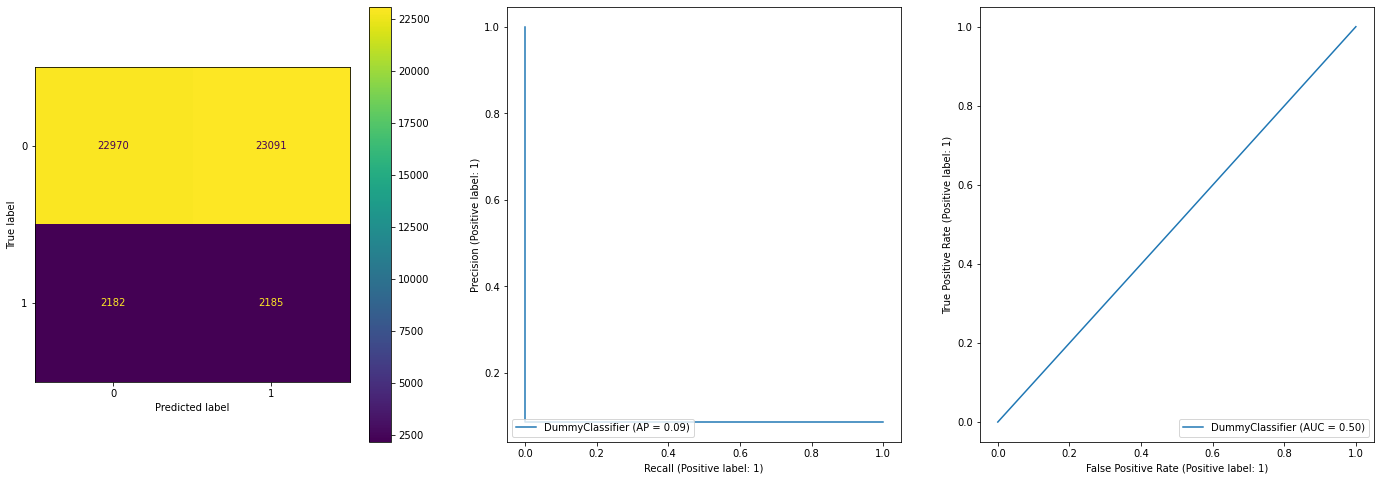

In [26]:
## Dummy Classifier
# https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html

# DummyClassifier permet de faire des prédictions aléatoires.


from sklearn.dummy import DummyClassifier


# Compute scores
dummy_results = models_helpers.find_best_params_classifier(
    X_train=X_train, y_train=y_train.values.ravel(), X_test=X_test, y_test=y_test,
    estimator=DummyClassifier(random_state=42),
    params={
        'strategy': ['stratified', 'most_frequent', 'prior', 'uniform']
    },
)
results = results.append(dummy_results, ignore_index=True)

# Plot best model curves
vis_helpers.plot_classifier_results(
    classifier=dummy_results['model'],
    X_test=X_test,
    y_test=y_test,
)

# 2.5s

Nous voyons l'effet du biais dû au déséquilibre des classes de `TARGET` : en prédisant systématiquement `0` (la classe majoritaire : pas de problème de remboursement) nous obtenons une Accuracy assez bonne (~0.9), ce qui n'est pas si mauvais pour un algorithme de décision "bête". Mais les autres indicateurs sont très mauvais, notamment la précision moyenne (`AP = 0.09`) et l'aire sous la courbe ROC (`ROC_AUC = 0.5`).

En revanche, celà signifie que le modèle prédit systématiquement que les clients n'auront pas de problème de remboursement, ce qui est dangeureux pour la banque. Il est primordial de mieux détecter les cas où il y a un risque de défaut (`TARGET=1`).


### Modèles linéaires


#### Modèle Ridge

Nous allons modéliser la variable `TARGET` comme une combinaison linéaire de nos autres variables. La régularisation permet de contenir les coefficients et donc d'éviter le sur-apprentissage.


n_iterations: 8
n_required_iterations: 8
n_possible_iterations: 8
min_resources_: 12
max_resources_: 34936
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 2800
n_resources: 12
Fitting 3 folds for each of 2800 candidates, totalling 8400 fits
----------
iter: 1
n_candidates: 934
n_resources: 36
Fitting 3 folds for each of 934 candidates, totalling 2802 fits
----------
iter: 2
n_candidates: 312
n_resources: 108
Fitting 3 folds for each of 312 candidates, totalling 936 fits
----------
iter: 3
n_candidates: 104
n_resources: 324
Fitting 3 folds for each of 104 candidates, totalling 312 fits
----------
iter: 4
n_candidates: 35
n_resources: 972
Fitting 3 folds for each of 35 candidates, totalling 105 fits
----------
iter: 5
n_candidates: 12
n_resources: 2916
Fitting 3 folds for each of 12 candidates, totalling 36 fits
----------
iter: 6
n_candidates: 4
n_resources: 8748
Fitting 3 folds for each of 4 candidates, totalling 12 fits
----------
iter: 7
n_candidates: 2
n_res

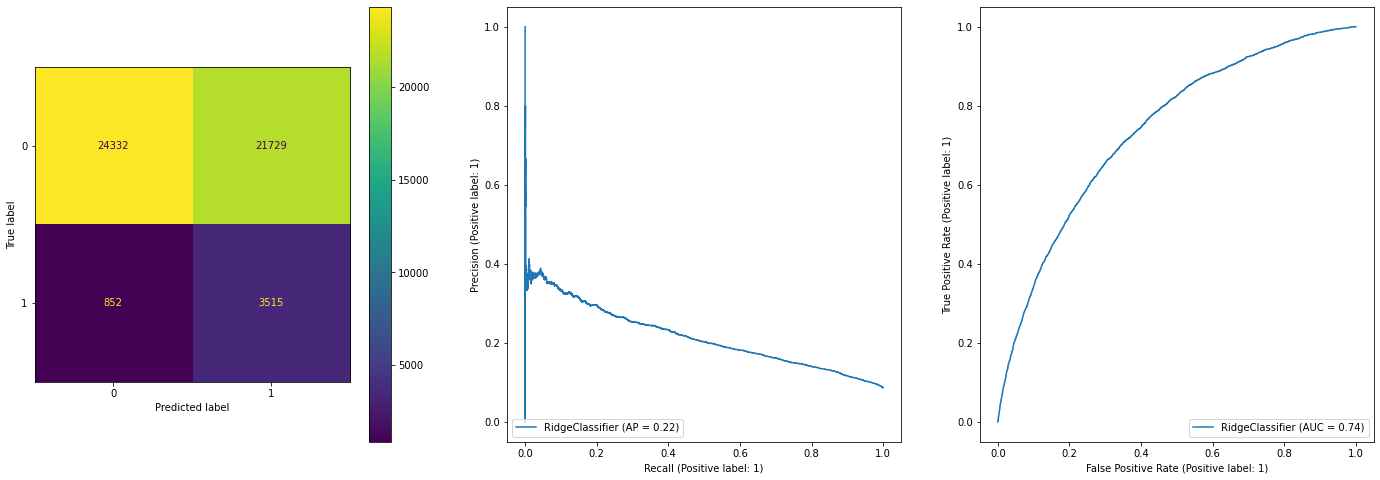

In [27]:
## Ridge Classifier (linear model)
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeClassifier.html
# RidgeClassifier is a linear model with a linear loss function. It is useful for regularized linear models.

# - La norme ℓ2 du vecteur de poids peut être utilisée comme terme de régularisation de la régression linéaire.
# - Cela s'appelle la régularisation de Tykhonov, ou régression ridge.
# - La régression ridge admet toujours une solution analytique unique.
# - La régression ridge permet d'éviter le surapprentissage en restraignant l'amplitude des poids.
# - La régression ridge a un effet de sélection groupée : les variables corrélées ont le même coefficient.


from sklearn.linear_model import RidgeClassifier


# Compute scores
ridge_results = models_helpers.find_best_params_classifier(
    X_train=X_train, y_train=y_train.values.ravel(), X_test=X_test, y_test=y_test,
    estimator=RidgeClassifier(random_state=42),
    params={
        'alpha': np.logspace(-10, 10, 50),
        'fit_intercept': [True, False],
        'normalize': [True, False],
        'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],
        'class_weight': [None, 'balanced'],
    },
)
results = results.append(ridge_results, ignore_index=True)

# Plot best model curves
vis_helpers.plot_classifier_results(
    classifier=ridge_results['model'],
    X_test=X_test,
    y_test=y_test,
)

# 45.6s

Avec une simple régression linéaire des variables d'entraînement, nous voyons que les résultats sont déjà meilleurs.

Voyons comment mesurer l'importance de chaque variable dans notre modèle.

In [28]:
# Let's plot the features importances
if DRAW_PLOTS:
    top_coefficients = pd.Series(
        ridge_results[
            'model'
        ].coef_[0],
        X_train.columns,
    ).map(abs).sort_values(ascending=False).head(20)

    fig = px.bar(
        top_coefficients,
        color=top_coefficients.values,
        title="Top 20 variables importance",
        labels={
            "index": "Variable name",
            "value": "Coefficient",
            "color": "Coefficient",
        },
        width=1200,
        height=800,
    )
    fig.show()

Nous voyons que les variables XXX jouent un rôle important dans ce modèle.


#### Modèle de Régression Logistique

Ici, nous modélisons la variable `TARGET` comme la probabilité d'appartenance à la classe positive en tant que transformation logistique d'une combinaison linéaire des variables.
Ce modèle est sensé mieux classifier les cas "difficiles".


n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 8
min_resources_: 12
max_resources_: 34936
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 200
n_resources: 12
Fitting 3 folds for each of 200 candidates, totalling 600 fits
----------
iter: 1
n_candidates: 67
n_resources: 36
Fitting 3 folds for each of 67 candidates, totalling 201 fits
----------
iter: 2
n_candidates: 23
n_resources: 108
Fitting 3 folds for each of 23 candidates, totalling 69 fits
----------
iter: 3
n_candidates: 8
n_resources: 324
Fitting 3 folds for each of 8 candidates, totalling 24 fits
----------
iter: 4
n_candidates: 3
n_resources: 972
Fitting 3 folds for each of 3 candidates, totalling 9 fits


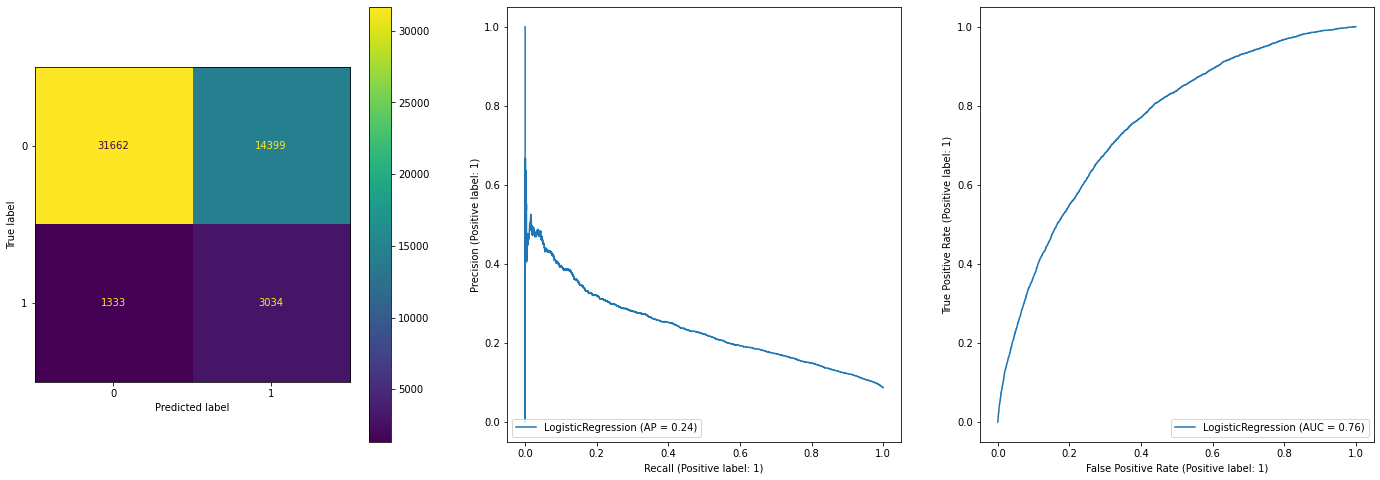

In [29]:
## Logistic Regression
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
# Logistic regression is a probabilistic, linear classifier. It is parametrized by a weight matrix
# and a bias vector. It is also able to fit non-linear decision boundaries, such as the
# logistic function found in Support Vector Machines.

# - La régression logistique modélise la probabilité qu'une observation appartienne à la classe positive comme une transformation logistique d'une combinaison linéaire des variables.
# - Les coefficients d'une régression logistique s'apprennent par maximisation de vraisemblance, mais il n'existe pas de solution explicite.
# - La vraisemblance est convexe, et de nombreux solveurs peuvent être utilisés pour trouver une solution numérique.
# - Les concepts de régularisation ℓ1 et ℓ2 s'appliquent aussi à la régression logistique.


from sklearn.linear_model import LogisticRegression


# Compute scores
logistic_results = models_helpers.find_best_params_classifier(
    X_train=X_train, y_train=y_train.values.ravel(), X_test=X_test, y_test=y_test,
    estimator=LogisticRegression(
        penalty='elasticnet',
        solver='saga',
        max_iter=10000,
        n_jobs=-1,
        random_state=42,
    ),
    params={
        'C': np.logspace(-5, 1, 10),
        'l1_ratio': np.linspace(0, 1, 10),
        'class_weight': [None, 'balanced'],
    },
)
results = results.append(logistic_results, ignore_index=True)

# Plot best model curves
vis_helpers.plot_classifier_results(
    classifier=logistic_results['model'],
    X_test=X_test,
    y_test=y_test,
)

# 26.2s

Ici, les résultats sont assez comparables à la régression Ridge.

Voyons comment nous pouvons mesurer l'importance des variables dans le modèle.


In [30]:
if DRAW_PLOTS:
    top_coefficients = pd.Series(
        logistic_results[
            'model'
        ].coef_[0],
        X_train.columns,
    ).map(abs).sort_values(ascending=False).head(20)

    fig = px.bar(
        top_coefficients,
        color=top_coefficients.values,
        title="Top 20 variables importance",
        labels={
            "index": "Variable name",
            "value": "Coefficient",
            "color": "Coefficient",
        },
        width=1200,
        height=800,
    )
    fig.show()

Nous pouvons aussi observer l'importance de chaque feature, selon le niveau de régularisation du modèle. Ceci nous indique quelles sont les variables les plus "importantes" : celles qui interviennent en premier dans le modèle et qui ont le coefficient le plus élevé (en valeur absolue).
Nous pouvons voir aussi quelles variables sont corrélées : ce sont celles qui ont un coefficient proche.


In [31]:
if DRAW_PLOTS:
    c_range = np.logspace(-8, 1, 20)
    l1_ratio = logistic_results['params']['l1_ratio']

    coefficients = pd.DataFrame(index=X_train.columns, columns=c_range)
    errors = []
    for c in c_range:
        logistic = LogisticRegression(C=c, l1_ratio=l1_ratio)
        logistic.fit(X_train, y_train)
        coefficients.loc[:, c] = logistic.coef_[0]
        errors.append(mean_squared_error(y_test, logistic.predict(X_test)))


    fig = go.Figure()
    for col in coefficients.index:
        fig.add_trace(go.Scatter(x=c_range, y=coefficients.loc[col, :], name=col,))

    fig.update_xaxes(type="log", autorange="reversed")
    fig.update_layout(
        title="Logistic regression coefficients as a function of the regularization",
        xaxis_title="log(C)",
        yaxis_title="coefficient",
        width=1200,
        height=600,
    )
    fig.show()

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=c_range, y=errors, name="MSE"))
    fig.update_xaxes(type="log", autorange="reversed")
    fig.update_layout(
        title="Logistic regression MSE as a function of the regularization",
        xaxis_title="log(C)",
        yaxis_title="MSE",
        width=1200,
        height=600,
    )
    fig.show()


Nous voyons que les variables XXX sont les plus importantes dans ce modèle.


### Modèle Machines à Vecteurs de Support (SVM)

Ici, nous allons chercher à trouver les lignes séparatrices entre les données de nos deux classes.


n_iterations: 6
n_required_iterations: 6
n_possible_iterations: 8
min_resources_: 12
max_resources_: 34936
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 360
n_resources: 12
Fitting 3 folds for each of 360 candidates, totalling 1080 fits
----------
iter: 1
n_candidates: 120
n_resources: 36
Fitting 3 folds for each of 120 candidates, totalling 360 fits
----------
iter: 2
n_candidates: 40
n_resources: 108
Fitting 3 folds for each of 40 candidates, totalling 120 fits
----------
iter: 3
n_candidates: 14
n_resources: 324
Fitting 3 folds for each of 14 candidates, totalling 42 fits
----------
iter: 4
n_candidates: 5
n_resources: 972
Fitting 3 folds for each of 5 candidates, totalling 15 fits
----------
iter: 5
n_candidates: 2
n_resources: 2916
Fitting 3 folds for each of 2 candidates, totalling 6 fits


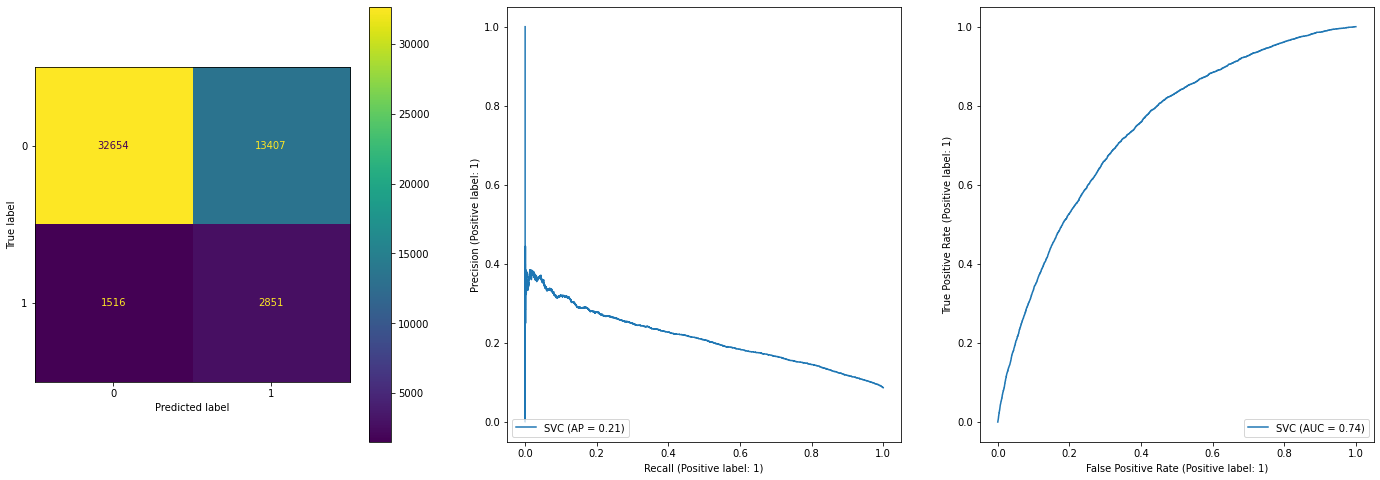

In [32]:
## Support Vector Machine
# https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
# Support Vector Machines (SVMs) are supervised learning models that learn to classify data points according to a set of hyperplanes.
# The model is based on the idea that the data points are separated by a hyperplane, and the hyperplane is the only way to classify the data points.
# The model is a linear classifier, meaning that it makes a linear decision boundary.
# The model is non-parametric, meaning that it does not require any parameters to be learned.
# The model is usually a good choice for handling unbalanced classes.
# The model is fast to train, and can be used for large datasets.

# Linear SVC
# - Les SVM (Support Vector Machines), aussi appelées en français Machines à Vecteurs de Support et parfois Séparatrices à Vaste Marge, cherchent à séparer linéairement les données.
# - La version primale résout un problème d'optimisation à p variables et est donc préférable si on a moins de variables que d'échantillons.
# - À l'inverse, la version duale résout un problème d'optimisation à n variables et est donc préférable si on a moins d'échantillons que de variables.
# - Les vecteurs de support sont les points du jeu de données qui sont les plus proches de l'hyperplan séparateur.
# - La fonction de décision peut s'exprimer uniquement en fonction du produit scalaire du point à étiqueter avec les vecteurs de support.

from sklearn.svm import SVC


# Compute scores
svc_results = models_helpers.find_best_params_classifier(
    X_train=X_train, y_train=y_train.values.ravel(), X_test=X_test, y_test=y_test,
    estimator=SVC(random_state=42),
    params={
        'C': np.logspace(-5, 1, 10),
        "gamma": ["scale", "auto"],
        "degree": range(2, 5),
        "kernel": ["linear", "poly", "rbf"],
        "class_weight": [None, 'balanced'],
    },
)
results = results.append(svc_results, ignore_index=True)

# Plot best model curves
vis_helpers.plot_classifier_results(
    classifier=svc_results['model'],
    X_test=X_test,
    y_test=y_test,
)

# 558.5s

Nous voyons que les résultats sont sensiblement identiques aux modèles précédents, mais le temps de prédiction est beaucoup plus long.

Le meilleur noyau étant linéaire, nous pouvons observer l'importance de chaque variables dans le modèle.


In [33]:
if DRAW_PLOTS:
    if svc_results['params']['kernel'] == 'linear':
        # if the kernel is linear, we can plot the variables importances
        top_coefficients = pd.Series(
            svc_results['model'].coef_[0],
            X_train.columns,
        ).map(abs).sort_values(ascending=False).head(20)

        fig = px.bar(
            top_coefficients,
            color=top_coefficients.values,
            title="Top 20 variables importance",
            labels={
                "index": "Variable name",
                "value": "Coefficient",
                "color": "Coefficient",
            },
            width=1200,
            height=800,
        )
        fig.show()
    else:
        # otherwise we can't plot the variables importances
        print("Cannot plot variables importances for non-linear kernel")


Nous voyons que les variables XXX sont les plus importantes.


### Modèles de Discriminant Analysis

Comme pour les SVM, ces modèles vont chercher à définir une séparation (linéaire ou quadratique) entre les classes.

#### Modèle Linear Discriminant Analysis

Ici, la séparation cherchée est linéaire.


n_iterations: 1
n_required_iterations: 1
n_possible_iterations: 8
min_resources_: 12
max_resources_: 34936
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 1
n_resources: 12
Fitting 3 folds for each of 1 candidates, totalling 3 fits


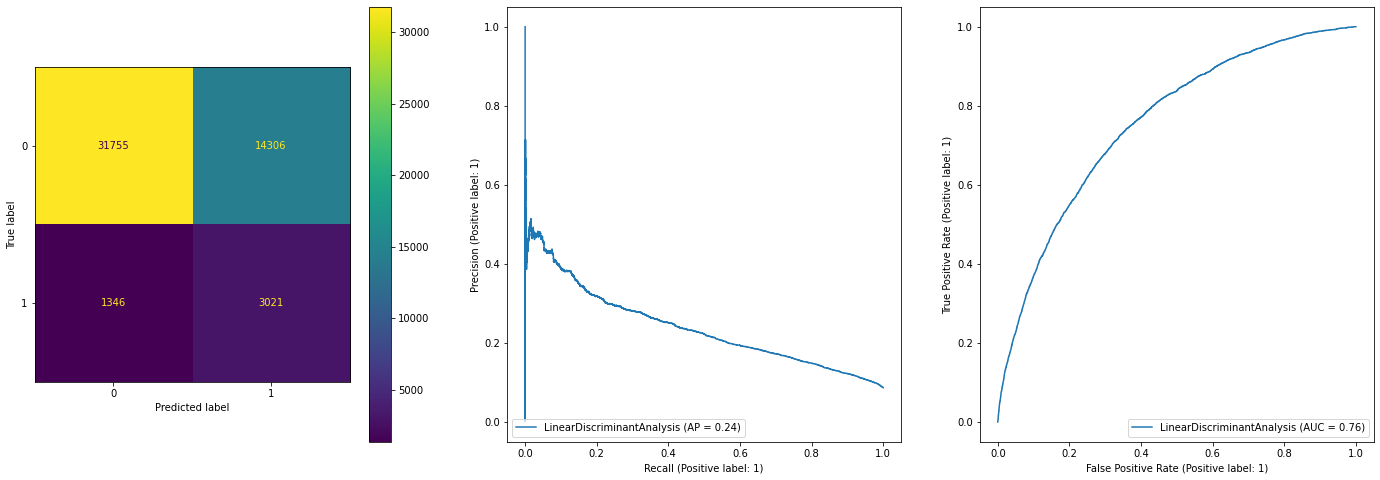

In [34]:
## Linear Discriminant Analysis
# https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html
# Linear Discriminant Analysis (LDA) is a supervised machine learning method that uses linear discriminant analysis to separate the features of the data into two groups.
# The method is a linear classifier, meaning that it makes a linear decision boundary.
# The method is non-parametric, meaning that it does not require any parameters to be learned.
# The method is usually a good choice for handling unbalanced classes.
# The method is fast to train, and can be used for large datasets.


from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


# Compute scores
lda_results = models_helpers.find_best_params_classifier(
    X_train=X_train, y_train=y_train.values.ravel(), X_test=X_test, y_test=y_test,
    estimator=LinearDiscriminantAnalysis(),
    params={},
)
results = results.append(lda_results, ignore_index=True)

# Plot best model curves
vis_helpers.plot_classifier_results(
    classifier=lda_results['model'],
    X_test=X_test,
    y_test=y_test,
)

# 3.5s

Les résultats sont toujours similaires.

Nous pouvons observer l'importance des variables.


In [35]:
if DRAW_PLOTS:
    top_coefficients = pd.Series(
        lda_results['model'].coef_[0],
        X_train.columns,
    ).map(abs).sort_values(ascending=False).head(20)

    fig = px.bar(
        top_coefficients,
        color=top_coefficients.values,
        title="Top 20 variables importance",
        labels={
            "index": "Variable name",
            "value": "Coefficient",
            "color": "Coefficient",
        },
        width=1200,
        height=800,
    )
    fig.show()

Nous voyons que les variables XXX sont les plus importantes.


#### Quadratic Discriminant Analysis


Ici, la séparation cherchée est quadratique (élipse, parabole ou hyperbole).


n_iterations: 1
n_required_iterations: 1
n_possible_iterations: 8
min_resources_: 12
max_resources_: 34936
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 1
n_resources: 12
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/clement/Workspace/oc_p4/env/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/clement/Workspace/oc_p4/env/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/clement/Workspace/oc_p4/env/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


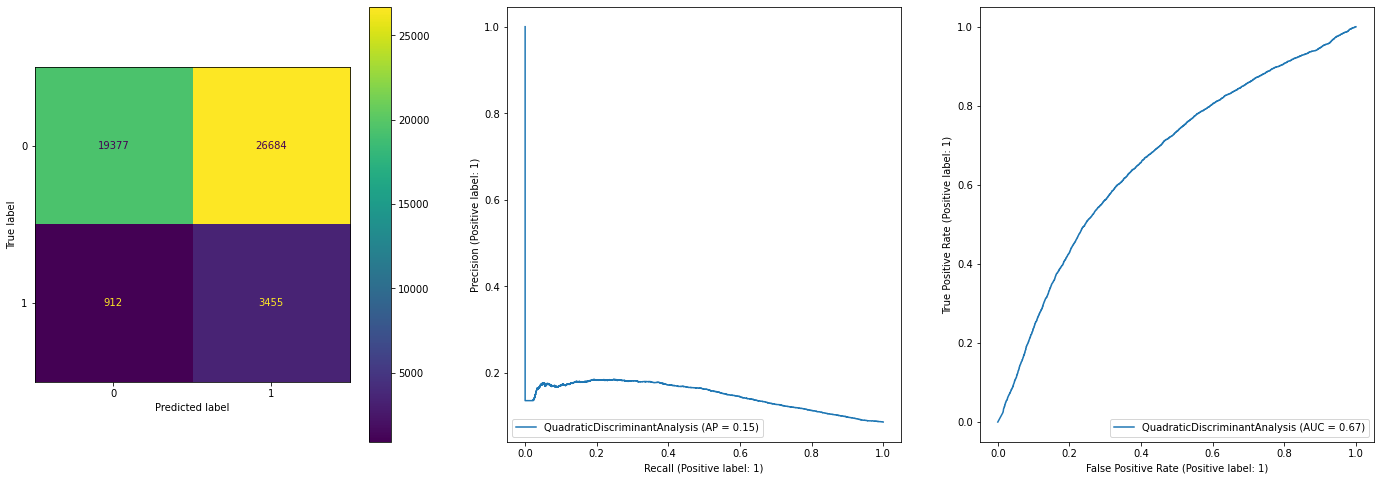

In [36]:
## Quadratic Discriminant Analysis
# https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis.html
# A classifier with a quadratic decision boundary, generated by fitting class conditional densities to the data and using Bayes’ rule.
# The model fits a Gaussian density to each class.
# The model is not necessarily the best model for the data, but it can be a useful baseline to compare the other models against.
# The model is non-parametric, meaning that it does not require any parameters to be learned.
# The model is fast to train, and can be used for large datasets.
# The model is not suitable for handling unbalanced classes.
# The model is not suitable for handling categorical features.


from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis


# Compute scores
qda_results = models_helpers.find_best_params_classifier(
    X_train=X_train, y_train=y_train.values.ravel(), X_test=X_test, y_test=y_test,
    estimator=QuadraticDiscriminantAnalysis(),
    params={},
)
results = results.append(qda_results, ignore_index=True)

# Plot best model curves
vis_helpers.plot_classifier_results(
    classifier=qda_results['model'],
    X_test=X_test,
    y_test=y_test,
)

# 2.7s

Nous voyons que ce modèle n'est pas adapté à notre problème : les résultats sont nettement moins bons qu'avec les modèles précédents.

Pour ce modèle, nous ne pouvons pas directement observer l'importance des variables, mais nous pouvons mesurer la sensibilité de la prédiction à la permutation de variables ( [Permutation feature importance](https://scikit-learn.org/stable/modules/permutation_importance.html#permutation-importance) )

In [37]:
if DRAW_PLOTS:
    # Permutation importance for Train data
    vis_helpers.plot_permutation_importance(
        qda_results['model'], 
        X_train, 
        y_train,
    )


In [38]:
if DRAW_PLOTS:
    # Permutation importance for Test data
    vis_helpers.plot_permutation_importance(
        qda_results['model'], 
        X_test, 
        y_test,
    )


En comparant les deux graphiques, nous pouvons observer que le modèle a "over-fitté" sur plusieurs variables (leur importance est très différente entre les jeux d'entraînement et de test) : `NAME_INCOME_TYPE_Working`, `NAME_INCOME_TYPE_Commercialassociate` . Mais les variables les plus importantes restent `EXT_SOURCE_{1-3}` et leurs combinaisons polynomiales.


### Modèle Naive Bayes

Ici, nous allons modéliser la variable `TARGET` comme la probabilité d'appartenir à la classe positive, sachant les autres variables, en s'appuyant sur le théorème de Bayes :
$$
P(y \mid x_1, \dots, x_n) = \frac{P(y) P(x_1, \dots, x_n \mid y)}
                                 {P(x_1, \dots, x_n)}
$$
sous la supposition "naive" que les variables sont indépendantes deux-à-deux :
$$
P(x_i | y, x_1, \dots, x_{i-1}, x_{i+1}, \dots, x_n) = P(x_i | y)
$$

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 8
min_resources_: 12
max_resources_: 34936
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 10
n_resources: 12
Fitting 3 folds for each of 10 candidates, totalling 30 fits
----------
iter: 1
n_candidates: 4
n_resources: 36
Fitting 3 folds for each of 4 candidates, totalling 12 fits
----------
iter: 2
n_candidates: 2
n_resources: 108
Fitting 3 folds for each of 2 candidates, totalling 6 fits


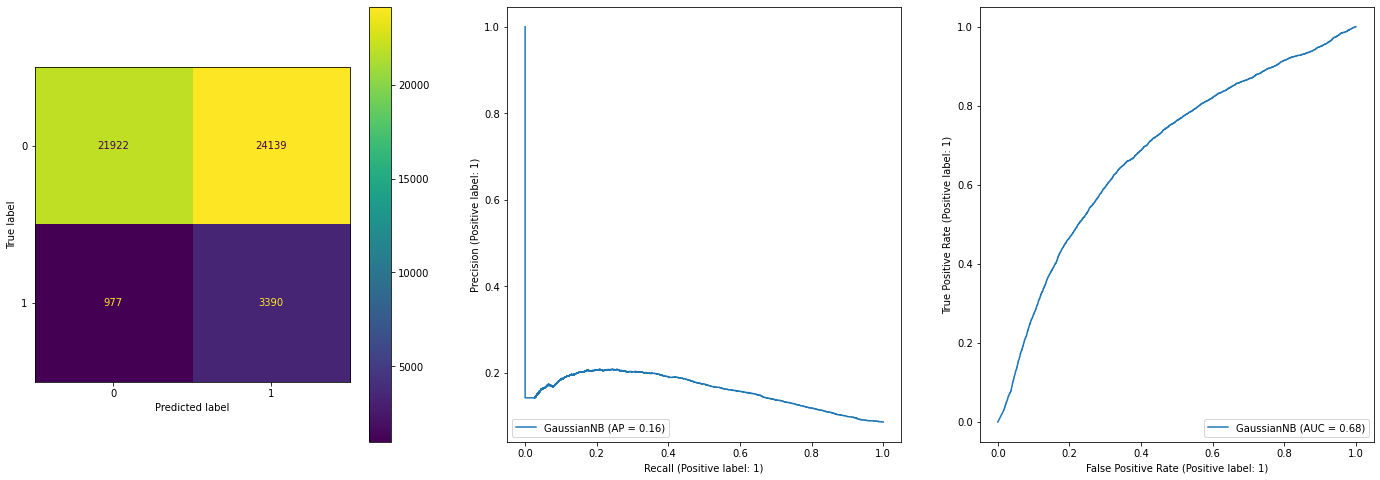

In [39]:
## Gaussian Naive Bayes (GaussianNB)
# https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html
# Naive Bayes methods are a set of supervised learning algorithms based on applying Bayes’ theorem with the “naive” assumption of conditional independence between every pair of features given the value of the class variable.
# Naive Bayes learners and classifiers can be extremely fast compared to more sophisticated methods. The decoupling of the class conditional feature distributions means that each distribution can be independently estimated as a one dimensional distribution. This in turn helps to alleviate problems stemming from the curse of dimensionality.
# On the flip side, although naive Bayes is known as a decent classifier, it is known to be a bad estimator, so the probability outputs from predict_proba are not to be taken too seriously.


from sklearn.naive_bayes import GaussianNB


# Compute scores
gnb_results = models_helpers.find_best_params_classifier(
    X_train=X_train, y_train=y_train.values.ravel(), X_test=X_test, y_test=y_test,
    estimator=GaussianNB(),
    params={
        "var_smoothing": np.logspace(-12, -3, 10),
    },
)
results = results.append(gnb_results, ignore_index=True)

# Plot best model curves
vis_helpers.plot_classifier_results(
    classifier=gnb_results['model'],
    X_test=X_test,
    y_test=y_test,
)

# 1.2s

Les résultats sont à nouveau relativement mauvais, ce modèle n'est pas adapté.

De plus, ce modèle ne nous permet pas de mesurer l'importance des variables pour effectuer les prédictions.


### K nearest neighbours

Ici, nous allons prédire la classe de nos données de test, simplement en regardant la classe de ses plus proches voisins. La supposition est que deux individus proches ("ressemblants") devraient avoir la même classe.


n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 8
min_resources_: 12
max_resources_: 34936
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 10
n_resources: 12
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/home/clement/Workspace/oc_p4/env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/clement/Workspace/oc_p4/env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/clement/Workspace/oc_p4/env/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/home/clement/Workspace/oc_p4/env/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/home/clement/Workspace/oc_p4/env/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 53, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/home/cle

----------
iter: 1
n_candidates: 4
n_resources: 36
Fitting 3 folds for each of 4 candidates, totalling 12 fits
----------
iter: 2
n_candidates: 2
n_resources: 108
Fitting 3 folds for each of 2 candidates, totalling 6 fits


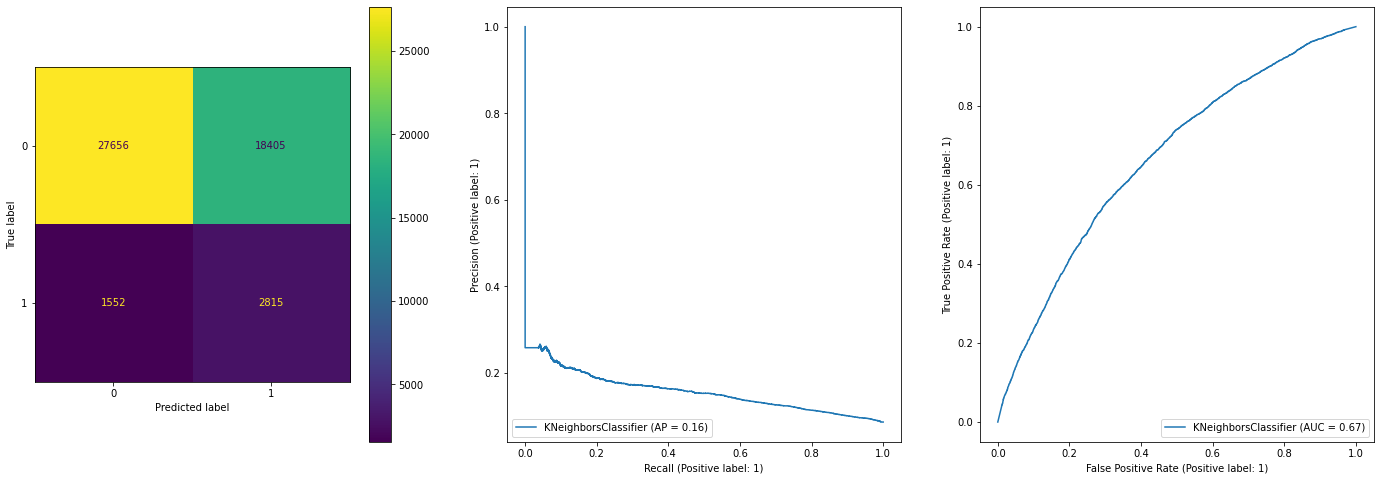

In [40]:
## K-nearest-neighbours
# https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
# K-nearest neighbors (KNN) is a non-parametric method used for classification and regression.


from sklearn.neighbors import KNeighborsClassifier


# Compute scores
knn_results = models_helpers.find_best_params_classifier(
    X_train=X_train, y_train=y_train.values.ravel(), X_test=X_test, y_test=y_test,
    estimator=KNeighborsClassifier(n_jobs=-1),
    params={
        "n_neighbors": range(2, 12, 2),
        "weights": ["uniform", "distance"],
    },
)
results = results.append(knn_results, ignore_index=True)

# Plot best model curves
vis_helpers.plot_classifier_results(
    classifier=knn_results['model'],
    X_test=X_test,
    y_test=y_test,
)

# 243.5s

Encore une fois, les résultats ne sont pas très bons et ce type de modèle ne permet pas d'interpréter l'importance des variables pour la prédiction.
De plus, le temps de prédiction est assez long (car il est nécessaire de calculer la distance entre plusieurs points).


### Modèles d'arbres de décision

Ici, nous allons essayer de construire un arbre de décision qui permette de choisir simplement la classe d'un individu.


n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 8
min_resources_: 12
max_resources_: 34936
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 224
n_resources: 12
Fitting 3 folds for each of 224 candidates, totalling 672 fits
----------
iter: 1
n_candidates: 75
n_resources: 36
Fitting 3 folds for each of 75 candidates, totalling 225 fits
----------
iter: 2
n_candidates: 25
n_resources: 108
Fitting 3 folds for each of 25 candidates, totalling 75 fits
----------
iter: 3
n_candidates: 9
n_resources: 324
Fitting 3 folds for each of 9 candidates, totalling 27 fits
----------
iter: 4
n_candidates: 3
n_resources: 972
Fitting 3 folds for each of 3 candidates, totalling 9 fits


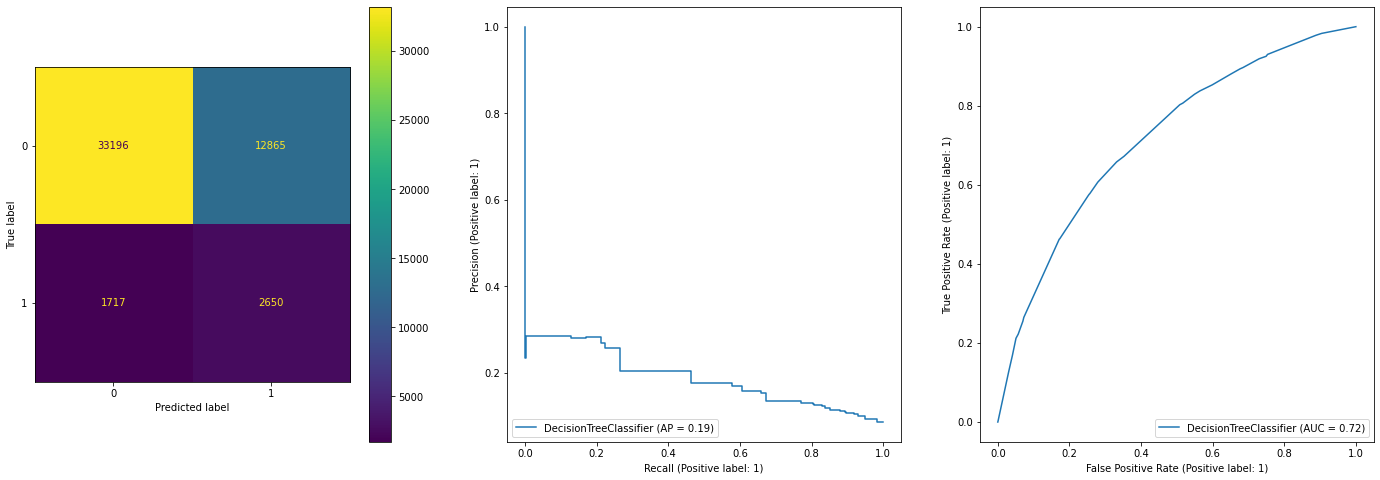

In [41]:
## Decisioon Tree
# https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
# Decision Trees (DTs) are a non-parametric supervised learning method used for classification and regression. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features. A tree can be seen as a piecewise constant approximation.


from sklearn.tree import DecisionTreeClassifier, plot_tree


# Compute scores
decision_tree_results = models_helpers.find_best_params_classifier(
    X_train=X_train, y_train=y_train.values.ravel(), X_test=X_test, y_test=y_test,
    estimator=DecisionTreeClassifier(random_state=42),
    params={
        "criterion": ['gini', 'entropy'],
        "splitter": ['best', 'random'],
        "max_depth": [None] + list(range(2, 20, 3)),
        "max_features": [None, 'auto', 'sqrt', 'log2'],
        "class_weight": [None, 'balanced'],
    },
)
results = results.append(decision_tree_results, ignore_index=True)

# Plot best model curves
vis_helpers.plot_classifier_results(
    classifier=decision_tree_results['model'],
    X_test=X_test,
    y_test=y_test,
)

# 6.2s

Nous voyons que les résultats ne sont pas très bons.

Mais nous pouvons observer l'importance des variables.

In [42]:
if DRAW_PLOTS:
    top_coefficients = pd.Series(
        decision_tree_results[
            'model'
        ].feature_importances_,
        X_train.columns,
    ).map(abs).sort_values(ascending=False).head(20)

    fig = px.bar(
        top_coefficients,
        color=top_coefficients.values,
        title="Top 20 variables importance",
        labels={
            "index": "Variable name",
            "value": "Coefficient",
            "color": "Coefficient",
        },
        width=1200,
        height=800,
    )
    fig.show()
    

Nous pouvons même observer l'arbre de décision qui a été appris par le modèle. Ceci a l'avantage d'être très concret et compréhensible par une personne du métier.


In [43]:
if DRAW_PLOTS:
    plt.figure(figsize=(50,20))
    plot_tree(
        decision_tree_results['model'],
        feature_names=X_train.columns,
        fontsize=8,
    )
    plt.show()


### Modèles ensemblistes

L'idée derrière les modèles ensemblistes est de combiner un (grand) nombre d'"apprenants faibles" (modèles très simples) afin de les faire voter et d'obtenir un consensus qui soit meilleur que chacun des modèles de base.


#### Modèle Bagging

Ici, nous combinons simplement plusieurs petits arbres de décision.


n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 8
min_resources_: 12
max_resources_: 34936
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 140
n_resources: 12
Fitting 3 folds for each of 140 candidates, totalling 420 fits
----------
iter: 1
n_candidates: 47
n_resources: 36
Fitting 3 folds for each of 47 candidates, totalling 141 fits
----------
iter: 2
n_candidates: 16
n_resources: 108
Fitting 3 folds for each of 16 candidates, totalling 48 fits
----------
iter: 3
n_candidates: 6
n_resources: 324
Fitting 3 folds for each of 6 candidates, totalling 18 fits
----------
iter: 4
n_candidates: 2
n_resources: 972
Fitting 3 folds for each of 2 candidates, totalling 6 fits


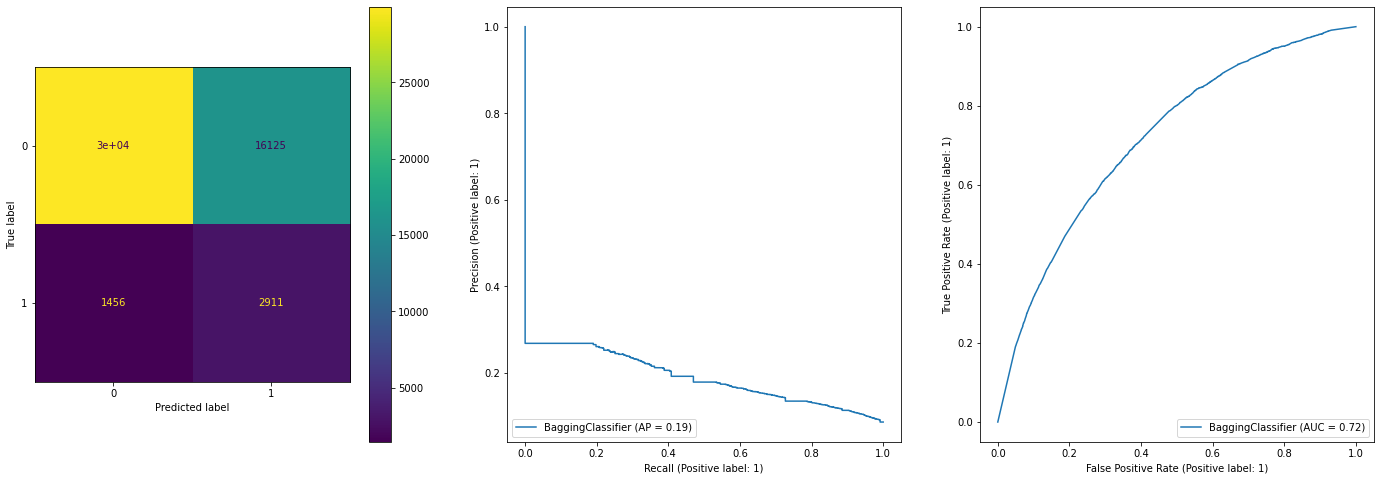

In [44]:
## Bagging
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html
# Bagging is a meta-estimator that fits base learners on random subsets of the dataset and use averaging to improve the predictive accuracy and control over-fitting.
# The base estimator is a decision tree.


from sklearn.ensemble import BaggingClassifier


# Compute scores
bagging_results = models_helpers.find_best_params_classifier(
    X_train=X_train, y_train=y_train.values.ravel(), X_test=X_test, y_test=y_test,
    estimator=BaggingClassifier(n_jobs=-1, random_state=42),
    params={
        "base_estimator": [DecisionTreeClassifier()] + [DecisionTreeClassifier(max_depth=x) for x in range(2, 20, 3)],
        "n_estimators": np.logspace(1, 3, 20).astype(int),
    },
)
results = results.append(bagging_results, ignore_index=True)

# Plot best model curves
vis_helpers.plot_classifier_results(
    classifier=bagging_results['model'],
    X_test=X_test,
    y_test=y_test,
)

# 181.8s

Les résultats sont ici un peu moins bons que les meilleurs modèles, mais tout de même corrects. En revanche, ce modèle ne permet pas d'évaluer l'importance des variables dans la prédiction.


### Random Forest

Ici, nous allons construire des forets d'arbres de décision sur des sous-ensembles de données.


n_iterations: 6
n_required_iterations: 6
n_possible_iterations: 8
min_resources_: 12
max_resources_: 34936
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 315
n_resources: 12
Fitting 3 folds for each of 315 candidates, totalling 945 fits
----------
iter: 1
n_candidates: 105
n_resources: 36
Fitting 3 folds for each of 105 candidates, totalling 315 fits
----------
iter: 2
n_candidates: 35
n_resources: 108
Fitting 3 folds for each of 35 candidates, totalling 105 fits
----------
iter: 3
n_candidates: 12
n_resources: 324
Fitting 3 folds for each of 12 candidates, totalling 36 fits
----------
iter: 4
n_candidates: 4
n_resources: 972
Fitting 3 folds for each of 4 candidates, totalling 12 fits
----------
iter: 5
n_candidates: 2
n_resources: 2916
Fitting 3 folds for each of 2 candidates, totalling 6 fits


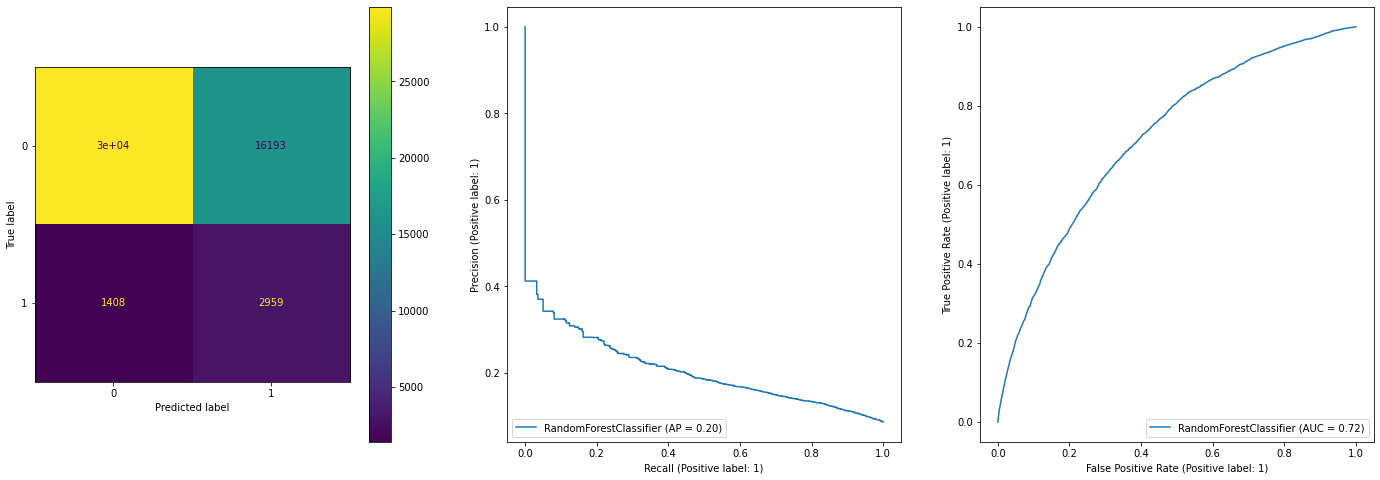

In [45]:
## Random Forest
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
# Random forest is a meta-estimator that fits a number of classifical decision trees on various sub-samples of the dataset and use averaging to improve the predictive accuracy and control over-fitting.
# The base estimator is a decision tree.


from sklearn.ensemble import RandomForestClassifier


# Compute scores
random_forest_results = models_helpers.find_best_params_classifier(
    X_train=X_train, y_train=y_train.values.ravel(), X_test=X_test, y_test=y_test,
    estimator=RandomForestClassifier(random_state=42),
    params={
        "n_estimators": np.logspace(1, 3, 5).astype(int),
        "max_depth": [None] + list(range(2, 20, 3)),
        "max_features": ["auto", "sqrt", "log2"],
        "class_weight": [None, 'balanced_subsample', 'balanced'],
    },
)
results = results.append(random_forest_results, ignore_index=True)

# Plot best model curves
vis_helpers.plot_classifier_results(
    classifier=random_forest_results['model'],
    X_test=X_test,
    y_test=y_test,
)

# 344.3s

Les résultats sont bons et nous pouvons observer l'importance des variables pour la prédiction.


In [46]:
if DRAW_PLOTS:
    top_coefficients = pd.Series(
        random_forest_results[
            'model'
        ].feature_importances_,
        X_train.columns,
    ).map(abs).sort_values(ascending=False).head(20)

    fig = px.bar(
        top_coefficients,
        color=top_coefficients.values,
        title="Top 20 variables importance",
        labels={
            "index": "Variable name",
            "value": "Coefficient",
            "color": "Coefficient",
        },
        width=1200,
        height=800,
    )
    fig.show()

Nous voyons que les variables XXX sont les plus importantes.


### Modèles de Boosting

Ici, nous allons utiliser des modèles de base, mais les "booster" en les mettant en compétition sur des sous-ensembles du jeu de données d'apprentissage.


#### XGBoost

XGBoost est un framework classique permettant de faire du bosting.


n_iterations: 1
n_required_iterations: 1
n_possible_iterations: 8
min_resources_: 12
max_resources_: 34936
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 1
n_resources: 12
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/clement/Workspace/oc_p4/env/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/clement/Workspace/oc_p4/env/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/clement/Workspace/oc_p4/env/lib/python3.9/site-p

[16:28:52] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:28:52] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:28:52] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/clement/Workspace/oc_p4/env/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/clement/Workspace/oc_p4/env/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/clement/Workspace/oc_p4/env/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/clement/Workspace/oc_p4/env/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/clement/Workspace/oc_p4/env/li

[16:29:19] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


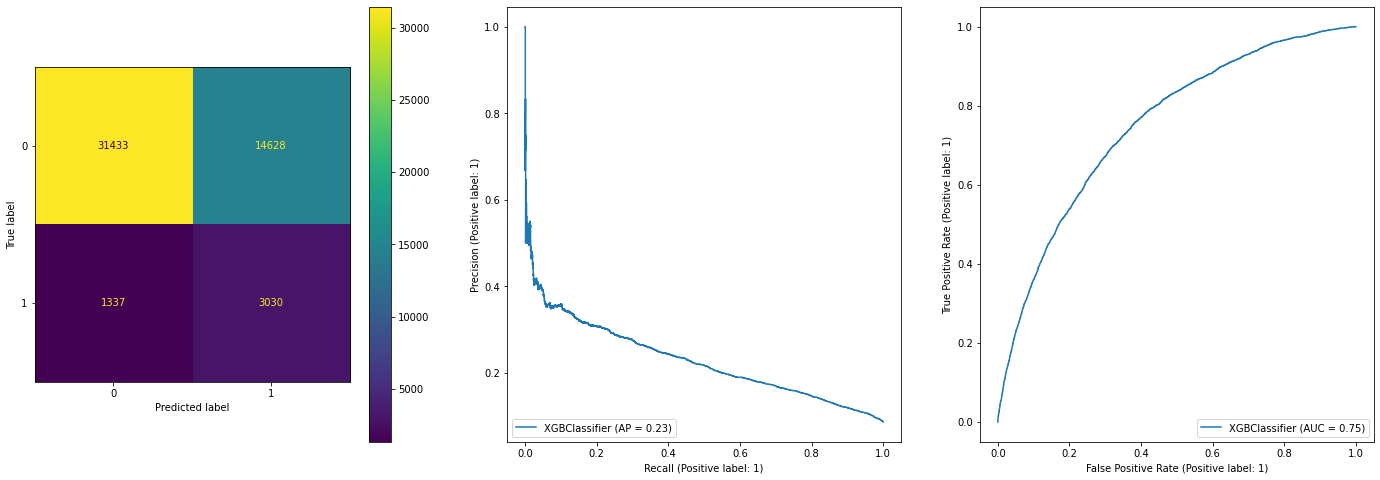

In [47]:
## XGBoost
# https://xgboost.readthedocs.io/en/latest/parameter.html
# XGBoost is a fast, scalable, high-performance gradient boosting framework.
# It supports both classification and regression.


from xgboost import XGBClassifier


# Hide warnings
warnings.filterwarnings(action='ignore', category=UserWarning)

# Compute scores
xgb_results = models_helpers.find_best_params_classifier(
    X_train=X_train, y_train=y_train.values.ravel(), X_test=X_test, y_test=y_test,
    estimator=XGBClassifier(
        objective='binary:logistic',
        n_jobs=-1,
        random_state=42,
    ),
)
results = results.append(xgb_results, ignore_index=True)

# Plot best model curves
vis_helpers.plot_classifier_results(
    classifier=xgb_results['model'],
    X_test=X_test,
    y_test=y_test,
)

# 53.4s

Les performances sont bonnes, mais pas les meilleures.

Nous pouvons observer l'importance des variables et l'arbre de décision généré.


In [48]:
from xgboost import plot_importance as xgb_plot_importance


if DRAW_PLOTS:
    # Plot feature importance
    xgb_plot_importance(
        booster=xgb_results['model'],
        max_num_features=20,
    )
    fig = plt.gcf()
    fig.set_size_inches(20, 10)


In [49]:
from xgboost import plot_tree as xgb_plot_tree


if DRAW_PLOTS:
    # Plot tree
    xgb_plot_tree(booster=xgb_results['model'], rankdir='LR')
    fig = plt.gcf()
    fig.set_size_inches(100, 50)


Il est alors très facile de comprendre comment classifier un individu.


#### LGBMClassifier

LightGBM est une autre bibliothèque de boosting classique.


n_iterations: 1
n_required_iterations: 1
n_possible_iterations: 8
min_resources_: 12
max_resources_: 34936
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 1
n_resources: 12
Fitting 3 folds for each of 1 candidates, totalling 3 fits


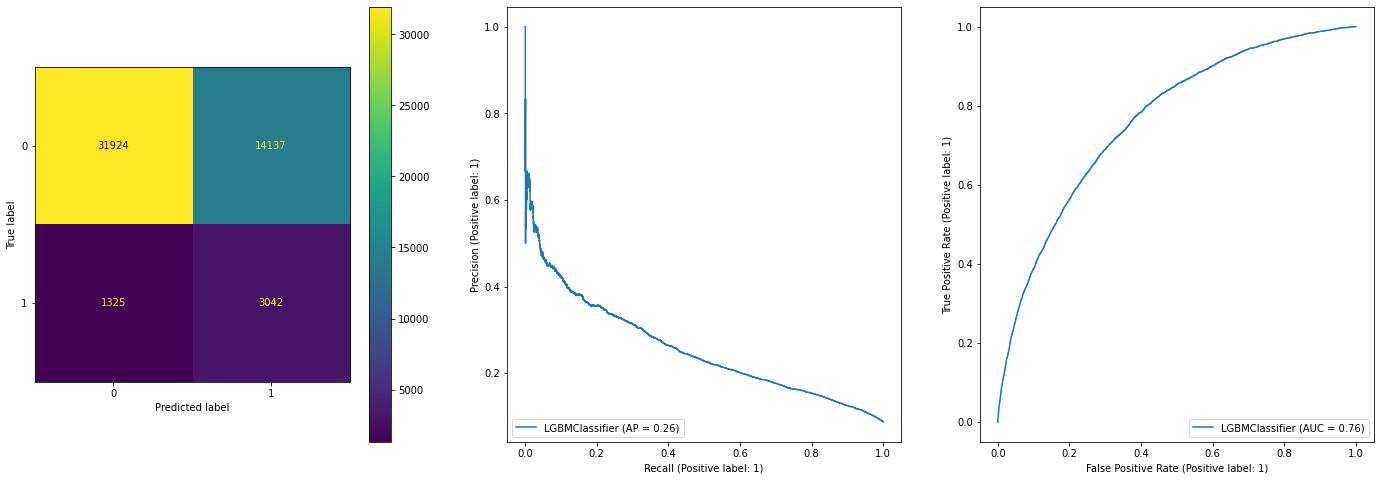

In [50]:
## LGBMClassifier
# https://lightgbm.readthedocs.io/en/latest/Parameters.html
# LightGBM is a fast, scalable, high performance gradient boosting library.
# It supports both classification and regression.


import re


X_train = X_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
X_test = X_test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))


from lightgbm import LGBMClassifier


# Compute scores
lgbm_results = models_helpers.find_best_params_classifier(
    X_train=X_train, y_train=y_train.values.ravel(), X_test=X_test, y_test=y_test,
    estimator=LGBMClassifier(
        objective='binary',
        n_jobs=-1,
        random_state=42,
    ),
)
results = results.append(lgbm_results, ignore_index=True)

# Plot best model curves
vis_helpers.plot_classifier_results(
    classifier=lgbm_results['model'],
    X_test=X_test,
    y_test=y_test,
)

# 3.5s

Les résultats ici sont les meilleurs observés et le temps de prediction est aussi assez bon.

Nous pouvons aussi observer l'importance des variables et un des arbres de décision arbre générés.


In [51]:
from lightgbm import plot_importance as lgbm_plot_importance


if DRAW_PLOTS:
    # Plot feature importance
    lgbm_plot_importance(
        booster=lgbm_results['model'],
        max_num_features=20,
        figsize=(20, 10),
    )
    plt.show()


In [52]:
from lightgbm import create_tree_digraph as lgbm_create_tree_digraph


if DRAW_PLOTS:
    # Plot tree
    lgbm_create_tree_digraph(booster=lgbm_results['model'])


### Modèle de réseau de neurones

Le perceptron permet d'apprendre des modèles paramétriques basés sur une combinaison linéaire des variables. Le perceptron permet d'apprendre des modèles de régression (la fonction d'activation est l'identité), de classification binaire (la fonction d'activation est la fonction logistique) ou de classification multi-classe (la fonction d'activation est la fonction softmax). Le perceptron est entraîné par des mises à jour itératives de ses poids grâce à l'algorithme du gradient. La même règle de mise à jour des poids s'applique dans le cas de la régression, de la classification binaire ou de la classification multi-classe. Empiler des perceptrons en un réseau de neurones multi-couches (feed-forward) permet de modéliser des fonctions arbitrairement complexes. C'est ce qui donne aux réseaux de neurones profonds la puissance prédictive qui fait actuellement leur succès.

L'entraînement de ces réseaux se fait par rétro-propagation. Attention, cet algorithme ne converge pas nécessairement, et pas nécessairement vers la solution optimale ! Plus il y a de paramètres (i.e. de poids de connexion), plus il faut de données pour pouvoir apprendre les valeurs de ces paramètres sans risquer le sur-apprentissage.

![One hidden layer Multi-layer Perceptron (MLP)](https://scikit-learn.org/stable/_images/multilayerperceptron_network.png)

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 8
min_resources_: 12
max_resources_: 34936
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 180
n_resources: 12
Fitting 3 folds for each of 180 candidates, totalling 540 fits
----------
iter: 1
n_candidates: 60
n_resources: 36
Fitting 3 folds for each of 60 candidates, totalling 180 fits
----------
iter: 2
n_candidates: 20
n_resources: 108
Fitting 3 folds for each of 20 candidates, totalling 60 fits
----------
iter: 3
n_candidates: 7
n_resources: 324
Fitting 3 folds for each of 7 candidates, totalling 21 fits
----------
iter: 4
n_candidates: 3
n_resources: 972
Fitting 3 folds for each of 3 candidates, totalling 9 fits
{'params': {'hidden_layer_sizes': (20, 50), 'alpha': 0.00042813323987193956}, 'score': 0.6124700889430675, 'predict_time': 0.24266862869262695}


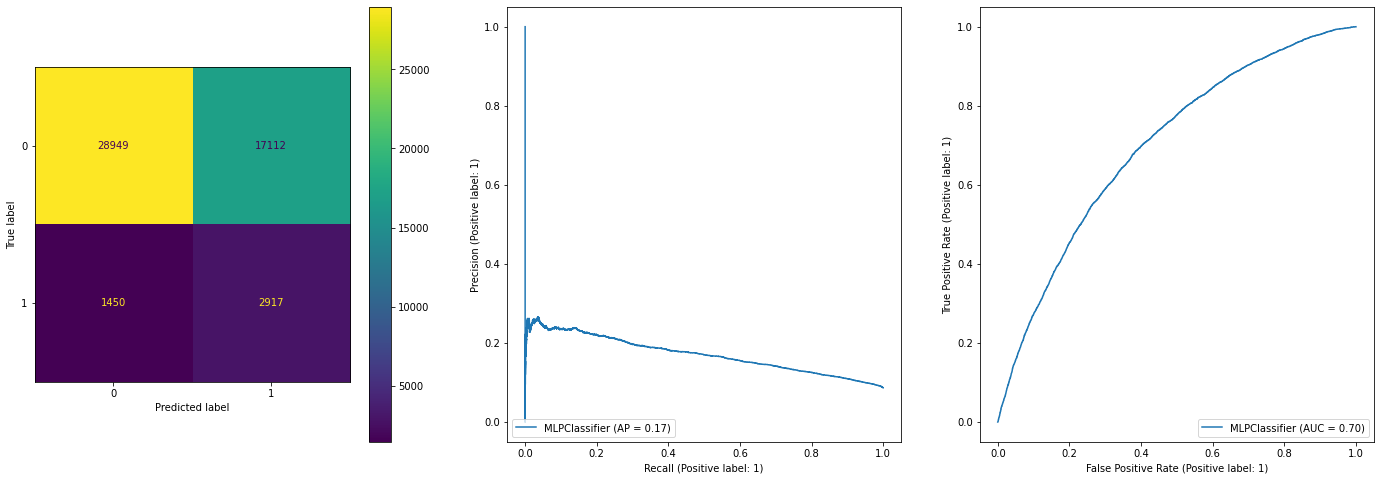

In [53]:
## Neural Network
# https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html
# Neural network is a supervised learning model that can learn nonlinear functions.
# It is a generalization of logistic regression, which is used for binary classification.


from sklearn.neural_network import MLPClassifier


# Compute scores
mlp_score = models_helpers.find_best_params_classifier(
    X_train=X_train, y_train=y_train.values.ravel(), X_test=X_test, y_test=y_test,
    estimator=MLPClassifier(
        max_iter=10000,
        random_state=42,
    ),
    params={
        "hidden_layer_sizes": [(10,), (10,20,), (10,20,50,), (10,50,20,), (20,), (20,50,), (50,20,), (50,), (100,)],
        "alpha": np.logspace(-8, 0, 20),
    },
)
print({
    "params": mlp_score['params'], 
    "score": mlp_score['score'],
    "predict_time": mlp_score['predict_time'],
})
results = results.append(mlp_score, ignore_index=True)

# Plot best model curves
vis_helpers.plot_classifier_results(
    classifier=mlp_score['model'],
    X_test=X_test,
    y_test=y_test,
)

# 224.7s

Les résultats observés ici sont bons, mais pas au niveau des meilleurs modèles. De plus, les réseaux de neurones ne permettent pas de voir l'importance des variables dans la prédiction.


### AutoML

Enfin, nous allons ici tester un outil qui automatise intégralement le choix du modèle et de ses hyper-paramètres.
Les seules contraintes sont des contraintes de "budget" : le temps alloué à la recherche du meilleur modèle.


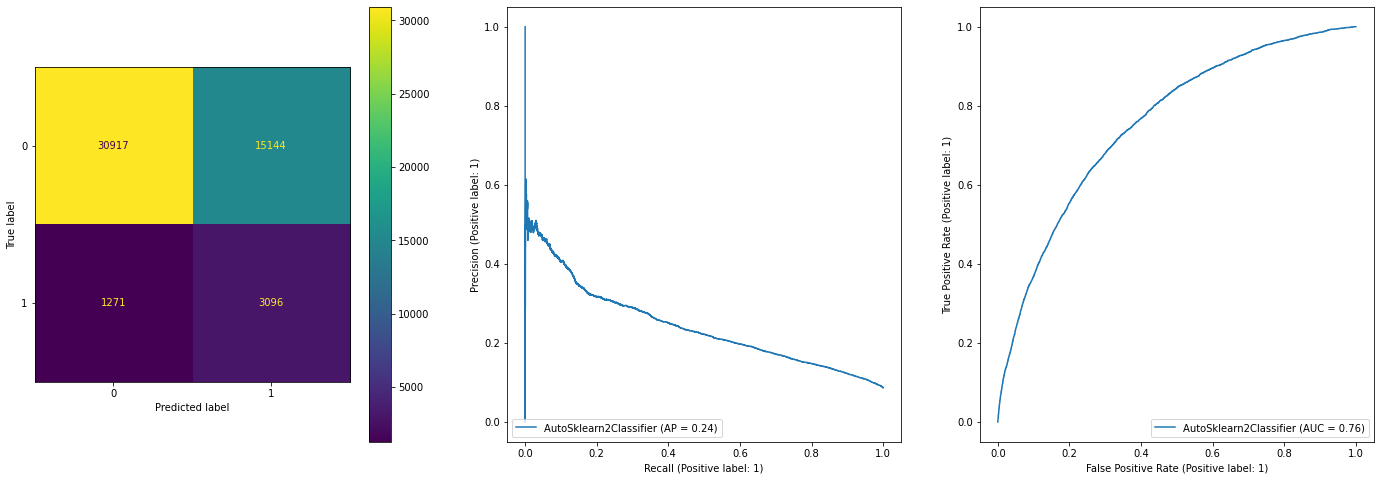

In [54]:
## AutoML
# https://automl.github.io/auto-sklearn/
# AutoML is a machine learning library that automatically tunes the hyperparameters of a machine learning model.
# It is a wrapper around scikit-learn, which is a machine learning library.


from autosklearn.experimental.askl2 import AutoSklearn2Classifier
from autosklearn.metrics import f1


# Compute scores
automl_score = models_helpers.automl_classifier(
    X_train=X_train, y_train=y_train.values.ravel(), X_test=X_test, y_test=y_test,
    estimator=AutoSklearn2Classifier(
        time_left_for_this_task=300,
        per_run_time_limit=60,
        metric=f1,
        n_jobs=-1,
    ),
)
results = results.append(automl_score, ignore_index=True)

# Plot best model curves
vis_helpers.plot_classifier_results(
    classifier=automl_score['model'],
    X_test=X_test,
    y_test=y_test,
)


## Conclusion

Nous avons testé plusieurs modèles, en cherchant à trouver pour chacun les meilleurs hyper-paramètres pour prédire si les futurs clients de la banque Home Credit présentent un risque de défaut de paiement ou non.


### Sélection du meilleur modèle

Nous pouvons alors les comparer afin d'en choisir un pour le tester sur de nouvelles prédictions.


In [55]:
# Let's display all the results
results


,model,params,score,predict_time,cv_results_,best_index_,confusion_matrix,f1,accuracy,precision,recall,average_precision,precision_recall_curve,roc_auc_score,roc_curve,classifier
0,"DummyClassifier(random_state=42, strategy='str...",{'strategy': 'stratified'},0.707071,0.003953,"{'iter': [0, 0, 0, 0, 1, 1], 'n_resources': [1...",5,"[[22970, 23091], [2182, 2185]]",0.147421,0.498830,0.086446,0.500343,0.086522,"([0.0865987149996034, 0.08644564013293242, 1.0...",0.499515,"([0.0, 0.5013134756084323, 1.0], [0.0, 0.50034...",HalvingRandomSearchCV(cv=StratifiedKFold(n_spl...
1,"RidgeClassifier(alpha=91029817.79915264, fit_i...","{'solver': 'saga', 'normalize': True, 'fit_int...",0.696528,0.005459,"{'iter': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",4201,"[[24332, 21729], [852, 3515]]",0.237412,0.552213,0.139241,0.804900,0.215898,"([0.08667606136990652, 0.08665793338890873, 0....",0.738932,"([0.0, 2.1710340635244567e-05, 2.1710340635244...",HalvingRandomSearchCV(cv=StratifiedKFold(n_spl...
2,"LogisticRegression(C=0.1, l1_ratio=1.0, max_it...","{'l1_ratio': 1.0, 'class_weight': None, 'C': 0.1}",0.671269,0.007508,"{'iter': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",300,"[[31662, 14399], [1333, 3034]]",0.278349,0.688030,0.174038,0.694756,0.239956,"([0.08697643848712382, 0.08695825366475463, 0....",0.755238,"([0.0, 2.1710340635244567e-05, 2.1710340635244...",HalvingRandomSearchCV(cv=StratifiedKFold(n_spl...
3,"SVC(C=0.1, class_weight='balanced', gamma='aut...","{'kernel': 'poly', 'gamma': 'auto', 'degree': ...",0.688900,106.578217,"{'iter': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",539,"[[32654, 13407], [1516, 2851]]",0.276461,0.704073,0.175360,0.652851,0.212597,"([0.08682426387259677, 0.08680610784157786, 0....",0.742250,"([0.0, 2.1710340635244567e-05, 2.1710340635244...",HalvingRandomSearchCV(cv=StratifiedKFold(n_spl...
4,LinearDiscriminantAnalysis(),{},0.388889,0.032468,"{'iter': [0], 'n_resources': [12], 'mean_fit_t...",0,"[[31755, 14306], [1346, 3021]]",0.278510,0.689617,0.174352,0.691779,0.239508,"([0.08691066133301491, 0.08689248895434462, 0....",0.755196,"([0.0, 2.1710340635244567e-05, 2.1710340635244...",HalvingRandomSearchCV(cv=StratifiedKFold(n_spl...
5,QuadraticDiscriminantAnalysis(),{},0.300000,0.158987,"{'iter': [0], 'n_resources': [12], 'mean_fit_t...",0,"[[19377, 26684], [912, 3455]]",0.200255,0.452764,0.114636,0.791161,0.147616,"([0.08663307411521981, 0.0866149542722241, 0.0...",0.665701,"([0.0, 0.013373569831310654, 0.013634093918933...",HalvingRandomSearchCV(cv=StratifiedKFold(n_spl...
6,GaussianNB(var_smoothing=1e-11),{'var_smoothing': 1e-11},0.643646,0.054498,"{'iter': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ...",14,"[[21922, 24139], [977, 3390]]",0.212566,0.501943,0.123143,0.776277,0.159222,"([0.08673631524588861, 0.08671817585953483, 0....",0.684842,"([0.0, 0.014871583335142529, 0.014893293675777...",HalvingRandomSearchCV(cv=StratifiedKFold(n_spl...
7,"KNeighborsClassifier(n_jobs=-1, n_neighbors=8,...","{'weights': 'distance', 'n_neighbors': 8}",0.638049,45.181999,"{'iter': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ...",15,"[[27656, 18405], [1552, 2815]]",0.220034,0.604248,0.132658,0.644607,0.156250,"([0.0865987149996034, 0.08855507868383405, 0.0...",0.666969,"([0.0, 0.010160439417294458, 0.010182149757929...",HalvingRandomSearchCV(cv=StratifiedKFold(n_spl...
8,DecisionTreeClassifier(class_weight='balanced'...,"{'splitter': 'best', 'max_features': 'sqrt', '...",0.591264,0.012780,"{'iter': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",334,"[[33196, 12865], [1717, 2650]]",0.266573,0.710835,0.170802,0.606824,0.188244,"([0.0865987149996034, 0.09341747361549342, 0.0...",0.718231,"([0.0, 0.0005644688565163588, 0.03028592518616...",HalvingRandomSearchCV(cv=StratifiedKFold(n_spl...
9,"(DecisionTreeClassifier(max_depth=2, random_st...","{'n_estimators': 1000, 'base_estimator': Decis...",0.625955,10.258023,"{'iter': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",209,"[[29936, 16125], [1456, 2911]]",0.248772,0.651364,0.152921,0.666590,0.188376,"([

In [56]:
# Plot prediction times per model
if DRAW_PLOTS:
    fig = go.Figure()
    
    for i in results.index:
        fig.add_trace(go.Bar(
            name=results.iloc[i,:]['model'].__class__.__name__ , 
            x=['Prediction Time'], 
            y=results.iloc[i,:][['predict_time']],
        ))
        
    fig.update_layout(
        title="Models prediction times",
        xaxis_title="Model",
        yaxis_title="Prediction time in s (log scale)",
        yaxis_type='log',
        width=1200,
        height=600,
    )
    fig.show()

Comme nous le voyons, certains modèles sont beaucoup plus rapides que d'autres. Les modèles `SVC`, `KNN`, `AutoSklearn`, `RandomForest` et `Bagging` sont les plus lents, tandis que les modèles `Dummy`, `Ridge`, `Logistic`, `DecisionTree` et `LDA` sont les plus rapides.


In [57]:
# Plot performance scores per model
if DRAW_PLOTS:
    fig = go.Figure()

    for i in results.index:
        fig.add_trace(go.Bar(
            name=results.iloc[i,:]['model'].__class__.__name__ , 
            x=['F1', 'Accuracy', 'Recall', 'Precision', 'Average Precision', 'ROC_AUC'], 
            y=results.iloc[i,:][['f1', 'accuracy', 'recall', 'precision', 'average_precision', 'roc_auc_score']],
        ))

    fig.update_layout(
        title="Models prediction scores",
        xaxis_title="Model",
        yaxis_title="Score",
        barmode='group',
        width=1200,
        height=600,
    )
    fig.show()

Nous voyons que globalement, le Recall est assez élevé, mais la Precision et le F1 ne sont généralement pas très bons. Ceci signifie que nous aurons plus de faux positifs que de faux négatifs, ce qui revient à une tendance à prédire trop souvent la classe positive, et donc avoir une politique de prêt plutôt précautionneuse : dans le doute, nous préférerons estimer que l'emprunteur présente un risque et donc préférer lui refuser le prêt, même s'il aurait pu ne pas faire défaut.

Sur la plupart des mesures, les moins bons modèles sont `Dummy`, `QDA`, `DecisionTree`, `GaussianNB` et `KNN`, tandis que les meilleurs sont `LDA`, `LGBM` et `AutoSklearn`.

Nous allons conserver le modèle `LGBM` qui a un temps de prédiction assez rapide et les meilleurs résultats.


### Explication du modèle

Nous avons vu précédemment quelles étaient les variables les plus importantes pour le modèle, et nous avons même pu visualiser un des arbres de décision générés dans ce modèle ensembliste boosté.

Nous allons maintenant observer comment les variables les plus importantes influencent les prédictions grâce aux méthodes [Partial Dependence (PD) et Individual Conditional Expectation (ICE)](https://scikit-learn.org/stable/modules/partial_dependence.html).

Nous visualiserons ensuite comment notre modèle effectue une prédiction.

In [58]:
if DRAW_PLOTS:
    # Let's plot the partial dependance graphs of the most important variables
    plot_partial_dependence(
        estimator=lgbm_results['model'], 
        X=X_train, 
        subsample=100,
        features=[
            'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 
            'ANNUITY_CREDIT_RATIO', 'ANNUITY_INCOME_RATIO',
            'DAYS_BIRTH', 'DAYS_EMPLOYED',
            'DAYS_LAST_PHONE_CHANGE', 'OWN_CAR_AGE',
        ],
        kind="both",
        n_jobs=-1,
    )

    fig = plt.gcf()
    fig.set_size_inches(24, 24)


Nous voyons bien que les clients qui ont le moins de risque d'avoir des problèmes de remboursement sont :
- les personnes ayant un `EXT_SOURCE_{1,3}` élevé
- les personnes ayant une forte capacité d'emprunt (`ANNUITY_INCOME_RATIO` faible)
- les personnes jeunes (`DAYS_BIRTH` élevé), mais embauchées depuis longtemps (`DAYS_EMPLOYED` faible)
- les personnes possédant une voiture et un téléphone plutôt ancien (`OWN_CAR_AGE` et `DAYS_LAST_PHONE_CHANGE` faible )


Observons maintenant quels critères sont utilisés par notre modèle pour effectuer une prédiction.

Nous allons utiliser dans un premier temps la méthode [Local Interpretable Model-agnostic Explanations (LIME)](https://christophm.github.io/interpretable-ml-book/lime.html#lime). Cette méthode permet de voir l'influence sur la prédiction de changements sur chaque variable de l'individu testé, afin d'évaluer l'importance de chaque variable dans la prise de décision. 


In [59]:
random_sample = 42

# Create the exlainer
explainer = LimeTabularExplainer(
    X_train.to_numpy(), 
    feature_names=X_train.columns,
)
exp = explainer.explain_instance(
    X_test.iloc[random_sample], 
    lgbm_results['model'].predict_proba, 
)

print(f"True value : { y_test.iloc[random_sample] }")
exp.show_in_notebook()


True value : 0


Nous voyons que nous avons un niveau de confiance assez élevé que ce client n'aura pas de problème de paiement (prédiction que `TARGET=0` à 76%).

Utilisons maintenant la méthode des [Shapley Values](https://christophm.github.io/interpretable-ml-book/shapley.html) qui permet aussi d'évaluer l'importance des variables dans la prédiction de la valeur cible.

In [137]:
# explain the model's predictions using SHAP
explainer = shap.Explainer(lgbm_results['model'])
shap_values = explainer.shap_values(X_test)

print(f"True value : { y_test.iloc[random_sample] }")
shap.force_plot(explainer.expected_value[1], shap_values[1][random_sample,:], X_test.iloc[random_sample,:])


True value : 0


Sur le même exemple que précédemment, nous voyons à nouveau que la classe prédite sera la classe "négative" (`TARGET=0`).

Comme avec la méthode LIME, les variables expliquant cette décision sont :
- `EXT_SOURCE_2` et `EXT_SOURCE_3` sont tous les deux élevés (`x1x2` élevé)
- c'est une personne plutôt jeune (`DAYS_BIRTH` élevé)
- la personne travaille dans une banque (`ORGANISATION_TYPE_Bank` élevé)
- le ratio credit / prix est assez bas : la personne doit avoir un apport (`CREDIT_PRICE_RATIO` faible)
- la personne est une femme (`CODE_GENDER_M` négatif)
- le montant des annuités est assez faible (`AMT_ANNUITY` faible)

En revanche, certains critères jouent tout de même contre cette prédiction :
- `EXT_SOURCE_1` est plutôt faible
- la personne s'est inscrite il y a plutôt longtemps (`DAYS_REGISTRATION` faible)
- la combinaison `EXT_SOURCE_1` x `EXT_SOURCE_3` est faible (`x0x2` faible)

La prédiction est effectivement correcte après vérification.



---

# Annexe

Les Notebooks Kaggle [Introduction: Home Credit Default Risk Competition](https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction) (et suivants) de [Will Koehrsen](https://www.kaggle.com/willkoehrsen) ont été d'une très grande aide dans l'exploration des données.

Comment bien choisir la métrique de score d'un algorithme de classification ?

![How to Choose a Metric for Imbalanced Classification](https://machinelearningmastery.com/wp-content/uploads/2019/12/How-to-Choose-a-Metric-for-Imbalanced-Classification-latest.png)